<a href="https://colab.research.google.com/github/juandmantilla/Prediccion-LQI-RSSI-series-de-tiempo/blob/master/Experimentos_CRAWDAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIMENTOS AUTOMATIZADOS

En este notebook se tratará de automatizar los procesos para la evaluación de los algoritmos de RF, SVR ARIMA y LSTM.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from os import listdir
from time import time

# ----------------------------- Carga de Modelos ----------------------
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

# ----------------------------- Carga de herramientas -----------------
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

# ----------------------------------------------------------------------




# Función que retorna un dataframe según las condiciones de nodeId y SrcNode
def cargarDatos(direccion):
    df = pd.read_csv(direccion)
    return df


# Función que realiza la diferencia entre una observación en el tiempo t con respecto a
# otra en el tiempo t-1. Los valores que corresponden a cero serán cambiados a 0.5 para
# evitar posibles indeterminaciones en el cálculo de erroes. 
def diferenciarSerie(datos, indicador):
    a = datos[[indicador]].diff(periods = 1).values
    a[0] = a[1]
    fecha = datos[["Date"]].values
    
    b = np.concatenate((fecha, a), axis = 1)
    
    datos = pd.DataFrame(data = b, columns=["Date", indicador])
    
    # Cambio de valores con 0 para evitar indeterminaciones
    datos.loc[datos[indicador] == 0, indicador] = 0.5

    plt.figure()
    correlacionarSerie(datos[[indicador]])
    plt.title(" Autocorrelación: Serie de tiempo de diferencias")
    plt.ylim([-0.25, 0.25])
    return datos
  

# Función que genera una serie de tiempo de promedios móviles. La ventana móvil
# indicada es de 5 observaciones temporales.
def promediarSerie(datos, indicador):
    datos = datos.rolling(5).mean()
    datos[indicador].fillna(0.5, inplace = True)
    return datos
    

# Función que genera 2 subconjuntos de datos. 
# * dataX corresponde a las observaciones X_t = Y_t-1
# * dataY corresponde a las observaciones en el tiempo t
def unPaso(datos, indicador):    
    dataX = np.array([])
    dataY = np.array([])
    
    for i in range(len(datos.values)):
        dataX = np.append(dataX, datos[[indicador]].values[i-1])
        dataY = np.append(dataY, datos[[indicador]].values[i])
    
    dataX[0] = 0
    
    return dataX, dataY


# Función que genera 2 subconjuntos de datos.
# * dataTransform[:, :-1] es una arreglo bidimensional que contiene los  t-n observaciones anteriores a t.
# * dataTransform[:, -1] es un arreglo unidimensional que contiene las observaciones en un tiempo t.
# Este algoritmo es basado en el recurso en línea: 
# https://stackoverflow.com/questions/48967169/time-delay-embedding-of-time-series-in-python
def multiplesPasos(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      # tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos + 1  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
    
    return dataTransform[:, :-1], dataTransform[:, -1]




#---------------------------------------------DEFINICIÓN DE MODELOS ------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------


# Función modeloRF realiza pretratamiento de datos genera; conjuntos de entrenamiento y prueba,
# el modelo de Random Forest Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor
def modeloRF(dataX, dataY, pasos, diferenciada, datosOriginales, indicador, porcentaje):

  # Generando el conjunto de datos. 80% de entrenamiento. Recuerde que shuffle indica que los valores
  # no se muevan aleatoriamente en el conjunto de datos
  fc = 0
  dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

  random = RandomForestRegressor(n_estimators=250, criterion = "mse",oob_score= True, max_depth = 150)
    
  pred = 0
    
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    tiempoInicial = time()

    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler, y_train)
    y_test =  invertirEscala(scaler, y_test)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    tiempoInicial = time()

    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler2, y_train)
    y_test =  invertirEscala(scaler2, y_test)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
        
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):

    tiempoInicial = time()

    fc = x_train.shape[0]
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i -1 ]
      b = np.append(b, a) 
        
    pred = b
    

    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
    
  # Con pasos y diferenciada
  elif((pasos > 1) and diferenciada == True):
  # Suma de numeros de filas y columnas para el desplazamiento

    tiempoInicial = time()

    fc = x_train.shape[0] + x_train.shape[1]
        
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

  return y_test, pred, y_train, tiempoEjecucion



# Función modeloSVM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de Support Vector Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR
def modeloSVM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador, porcentaje):

  dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

  svr = SVR(kernel="rbf", gamma="scale")
  pred = 0
  fc = 0
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    tiempoInicial = time()

    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler, y_train)
    y_test =  invertirEscala(scaler, y_test)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):

    tiempoInicial = time()


    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))

    y_train = invertirEscala(scaler2, y_train)
    y_test =  invertirEscala(scaler2, y_test)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):
    tiempoInicial = time()

    fc = x_train.shape[0]

    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
    pred = invertirEscala(scaler, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):  
      a = pred[i] + datosOriginales[indicador].values[fc + i -1]
      b = np.append(b, a) 

    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
    
  # Con pasos y diferenciada
  elif(pasos > 1 and diferenciada == True):
    tiempoInicial = time()

    fc = x_train.shape[0] + x_train.shape[1]
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
    pred = invertirEscala(scaler2, pred.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

  return y_test, pred, y_train, tiempoEjecucion


# Función modeloARIMA realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de ARIMA, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de prueba, regresiones (renombrado como predicciones)

# Este algoritmo es basado en el recurso en línea: 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def modeloArima(datos, pasosTemp ,pasosDif ,indicador, porcentaje):
    tiempoInicial= time()
    
    datos = datos[[indicador]].values
    datos = datos.astype("float32")
    
    # Creando conjunto de entrenamiento y prueba
    num = 1 - int(len(datos)*porcentaje)

    entrenamiento, prueba = datos[:num], datos[num:]

    # Como por cada observación y posterior proyección se debe analizar observaciones anteriores, entonces se debe
    # entrenar el modelo para cada observacion proyectada

    #Copia de entrenamiento. Ese arreglo guarda valores nuevos del arreglo de prueba.
    #Para garantizar que el modelo ARIMA se entrene con los valores posteriores a las observaciones de entrenamiento
    h = [i for i in entrenamiento]

    predicciones = []

    #Por cada observación de prueba se genera la proyección con respecto a las observaciones de test
    for i in range(len(prueba)):

        # --> Parámetros de ARIMA (p, d, q).
        # p: Indica la cantidad de observaciones que se tendrán en cuenta para realizar las proyecciones.
        # d: Indica la cantidad de pasos en la cual se aplica la diferencia en la serie temporal
        # q: Indica el tamaño de la ventana del promedio móvil.
        modeloArima = ARIMA(h, order=(pasosTemp, pasosDif, 0))
        modeloEntrenado = modeloArima.fit(disp = 0, trend = "nc" )

        # Predicción de observación para la observación t+1 de entrenamiento
        salida = modeloEntrenado.forecast()

        predTime = salida[0]
        predicciones.append(predTime)

        #Obteniendo valor real de la observación en tiempo t+1
        obs = prueba[i]

        #Añadiendo al vector para que se entrene nuevamente con este valor en la siguiente iteración.
        h.append(obs)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

    return prueba, predicciones, num, tiempoEjecucion


# Función para arreglos unidimensionales. Función para transformar el dominio
# de los datos. Retorna datos escalados con su respectivo escalador (scaler).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
def cambiarEscala(dataX, dataY, pasos):
  if (pasos == 1):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX.reshape(-1, 1))

    dataX = dataX.reshape(-1, 1)
    dataX = scaler.transform(dataX)

    dataY = dataY.reshape(-1, 1)
    dataY = scaler.transform(dataY)
    
    scaler2 = 0

  elif (pasos > 1):

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX)

    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    scaler2 = scaler2.fit(dataY.reshape(-1, 1))

    dataX = scaler.transform(dataX)
    dataY = scaler2.transform(dataY.reshape(-1, 1))

  return dataX, dataY, scaler, scaler2


# Función de inversión de escala de datos, retorna datos en el dominio original 
def invertirEscala(scaler, datos):
    datos = scaler.inverse_transform(datos)
    return datos


# -------------------------------------- MODELO LSTM  ----------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------


# Función modeloLSTM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de red LSTM, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
def modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,
              numNeuronas, batch_size, numEpoc, porcentaje):
  fc = 0
  pred = np.array([])
  y_test = np.array([])

  # 1 pasos sin diferenciar ----------------------------------------------------
  if ((pasos == 1) and diferenciada == False):

    tiempoInicial = time()

    # Generando el conjunto de datos. 60% de entrenamiento. Recuerde que shuffle indica que los valores
    # no se muevan aleatoriamente en el conjunto de datos
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje, shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25,input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict) 
    y_test = invertirEscala(scaler, y_test)

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

  # Pasos sin diferenciar ----------------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == False):
    tiempoInicial = time()

    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    y_test = invertirEscala(scaler2, y_test)


    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial
    

  # 1 paso y diferenciada ---------------------------------------------------------------------------
  elif ((pasos == 1) and diferenciada == True):
    tiempoInicial = time()

    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    fc = x_train.shape[0]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    #y_test = invertirEscala(scaler, y_test)

    
    #Transformar datos para el dominio original
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i -1 ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

  # Pasos y diferenciada --------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == True):
    tiempoInicial = time()

    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=porcentaje,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas,dropout = 0.25, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    #y_test = invertirEscala(scaler2, y_test)
    
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i -1]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

    tiempoFinal = time()
    tiempoEjecucion = tiempoFinal - tiempoInicial

  return y_test, pred, y_train, tiempoEjecucion



#---------------------------------------ERRORES---------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------


# Función errores retorna los diferentes métricas de error con respecto
# a los datos de prueba y las predicciones.
def errores(y_test, pred):

  # Función mean_absolute_percentage_error es basado en el recurso en línea:
  # https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
  def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


  MSE =  round(mean_squared_error( y_test.reshape(-1, 1) , pred), 3)
  MAPE = round( mean_absolute_percentage_error(y_test.reshape(-1, 1), pred) , 3)
  MAE =  round( mean_absolute_error(y_test.reshape(-1, 1), pred), 3)
  MedianAE = round( median_absolute_error(y_test.reshape(-1, 1), pred), 3)
  maxError = round(max_error(y_test.reshape(-1, 1), pred), 3)
  r2 =   round(r2_score(y_test.reshape(-1, 1), pred), 3)

  return MSE, MAE, MAPE, MedianAE, maxError,r2 


  
#-----------------------------------------MOSTRAR SERIE-------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
cont = 0

# Función que grafica la serie temporal predicha
def mostrarSerie(datosOriginales,  y_train, pred, indicador, modelo, pasos, diferencia):
  plt.plot(datosOriginales[["Date"]][ y_train.shape[0]: y_train.shape[0] + pred.shape[0] ], pred, label = modelo )
  global cont
  if (cont == 0):
    num = y_train.shape[0]
    plt.axvline(x = datosOriginales[["Date"]][num: num + 1].values, linestyle='--', color = "plum", label= "Test")
    cont = cont + 1
  elif ( cont >= 1 ):
    cont = cont + 1
    if (cont == 3):
      cont = 0

    
# Función que grafica la serie temporal predicha realizada por el modelo ARIMA
def mostrarSerieARIMA(datosOriginales, pred, num, indicador, modelo):
  plt.plot(datosOriginales[["Date"]][num:], pred, label = modelo)
  

# Función que asigna los títulos, etiquetas y demás a la gráfica de la serie temporal
def labelSerie(datosOriginales, indicador, pasos):
  #Imprimir serie temporal real
  plt.plot(datosOriginales[["Date"]], datosOriginales[[indicador]].values, color="dimgray", label = "Original", alpha = 0.5)
  plt.legend()

  num = int (len(datosOriginales[[indicador]])*0.5)
  array = [datosOriginales[["Date"]].values[num], datosOriginales[["Date"]].values[-1]]
  

  #Título y subtítulo del gráfico
  plt.title("Forecasting" )
  plt.suptitle("Timestep : " + str(pasos))
  plt.xlabel("Experiment Number")
  plt.xlim((4800, 5300))
  plt.ylabel(str(indicador))
    

#-----------------------------------------DIAGRAMAS DE CAJAS-----------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

def cajasBigotes(RF, SVM, ARIMA, LSTM):
  plt.figure(figsize=(15, 5))
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  ARIMA = np.array(ARIMA).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, ARIMA, LSTM), sym="o", labels=["RF", "SVM", "ARIMA", "LSTM"])
  plt.title("Diagrama de cajas")

def cajasBigotes2(RF, SVM, LSTM):
  plt.figure(figsize=(15, 5))
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, LSTM), sym="o", labels=["RF", "SVM", "LSTM"])
  plt.title("Diagrama de cajas")


#----------------------------------------- PRUEBA DE AUTOCORRELACIÓN---------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que grafica la serie temporal correlacionada consigo misma.
# Este algoritmo está basado en el recurso en línea : 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html

def correlacionarSerie(datos):
  autocorrelation_plot(datos)
  


#----------------------------------------- REALES VS PREDICHOS---------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que grafica en un plano los valores reales de la serie de tiempo vs los valores predichos

def realesPredichos(pred, y_test, modelo, i, ax):
  ax[i].scatter(pred, y_test)
  ax[i].title.set_text(modelo)
  ax[i].set_xlabel("Predicho")
  ax[i].set_ylabel("Real")

#----------------------------------------- HISTOGRAMA ERROR------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que imprime en pantalla los errores de cada modelo.

  




## **Prueba Dickey-Fuller**

La prueba de Dickey-Fuller aumentada puede utilizarse para **comprobar la raíz unitaria** en un proceso univariado en presencia de una correlación en serie.

---
**Hipótesis nula (H0):** Si no se rechaza, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que **no es estacionaria**. Tiene una estructura dependiente del tiempo.
    
**Hipótesis Alternativa (H1):** La hipótesis nula es rechazada; sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que **es estacionaria** . No tiene una estructura dependiente del tiempo.

---

Valor ***p > 0,05:*** Si no se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.
  
Valor ***p <= 0,05:*** Rechazar la hipótesis nula (H0), el dato no tiene una raíz unitaria y es estacionario.

In [5]:
# Este algoritmo está basado en los recursos en línea : https://machinelearningmastery.com/time-series-data-stationary-python/ y en
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

def pruebaDickeyFuller(datos):
  print("---------------------- DICKEY - FULLER ----------------------")
  resultado = adfuller(datos)
  print("ADF Estadistico: %f" % resultado[0])
  print("Valor p: %f" % resultado[1])
  print("Valores críticos")
  for key, value in resultado[4].items():
      print('\t%s: %.5f' % (key, value))
  print("-------------------------------------------------------------")

# **FUNCIÓN EJECUTAR MODELOS**

In [6]:
#Parámetro diferencia hace referencia a un booleano para indicar si la serie que se usa es diferenciada
# dataX, dataY, pasos, diferenciada, datosOriginales, indicador
a = 0
def ejecutarModelos(diferencia, promediada, path, indicador, numNeuronas, epocas, porcentaje, pasosHistoricos ):
    
    #Guarda en variable los datos cargados. Evitar cargar varias veces.
    datos = cargarDatos(path)
    
    
    #Diccionarios que guardan los errores de los modelos
    dicRF = {}
    dicSVM = {}
    dicARIMA = {}
    dicLSTM = {}

    #Diccionarios que guardan los tiempos de ejecución de los modelos
    timeRF = {}
    timeSVM = {}
    timeARIMA = {}
    timeLSTM = {}

    #--------------- PRUEBA DE AUTOCORRELACIÓN y DICKEY - FULLER---------------------------------

    # Resultados de la prueba de Dickey-Fuller a la serie temporal original
    
    serie = datos.values[:, -1]

    pruebaDickeyFuller(serie)

    correlacionarSerie(serie)
    plt.title(" Autocorrelación: Serie de tiempo sin diferencias")
    plt.ylim([-0.25, 0.25])
    #---------------------------------------------------------------------------------------------


    if (diferencia == False and promediada == False ):
        print ("----------------------- SIN DIFERENCIAS ---------------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1 ):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = unPaso(datos, indicador)    #----> Sólo para RF Y SVM
                
                #Creación de objeto plt
                plt.figure(figsize=(15, 5))
                                
                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                
                                
                ARIMA = modeloArima(datos, i, 0, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                                
               # modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,numNeuronas, batch_size, epochs):
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                
                #labelSerie imprime el títulos, label y timestap
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                # PREDICHOS VS REALES
                
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

                                                
            elif( i > 1 and i <= 5):

                #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                
                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                

                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                

                ARIMA = modeloArima(datos, i, 0, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA" )
                
                                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                
                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]
                
            elif ( i > 5):
            #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                
                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)


                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                
                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))
                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                 

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

        return dicRF, dicSVM, dicARIMA, dicLSTM
    
    elif (diferencia == True and promediada == False):
        
        print ("-----------------------  SERIE DE DIFERENCIAS -----------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = unPaso(datosML, indicador)    #----> Para RF, SVM Y LSTM

                plt.figure(figsize=(15, 5))
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)

                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                plt.legend("RF")

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                plt.legend("SVM")

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

            elif( i>1 and i<=5):
                
                datosML = diferenciarSerie(datos, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
               
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

                
            elif ( i > 5):
                datosML = diferenciarSerie(datos, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
               
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]
        
    elif(diferencia == True and promediada == True):
        
        print ("---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------")
        
        for i in range(pasosHistoricos, pasosHistoricos + 1):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie(datosML, indicador)
                datosML = unPaso(datosML, indicador) 

                #datos promediados para ARIMA
                datosProm = promediarSerie(datos, indicador)

                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datosProm, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")

                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                labelSerie(datos, indicador, i)
                
                #Diagramas de cajas
              
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

            elif(i>1 and i<=5):

                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador, porcentaje)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(ARIMA[0], ARIMA[1], "ARIMA", 2, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])
                
                #Reales vs Predichos


                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA : " + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeARIMA["Tiempo modelo ARIMA : " + str(i)] = ARIMA[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

            elif (i>5):
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador, porcentaje)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas, porcentaje)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                
                cajasBigotes2(RF[1], SVM[1], m_LSTM[1])

                # PREDICHOS VS REALES
                fig, ax = plt.subplots(1, 4, figsize= (15, 5))

                realesPredichos(RF[0], RF[1], "RF", 0, ax)
                realesPredichos(SVM[0], SVM[1], "SVM", 1, ax)
                realesPredichos(m_LSTM[0], m_LSTM[1], "LSTM", 3, ax)

                 


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])
                
                #Reales vs Predichos


                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR : " + str(i)] = errorSVM
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                #Guardar tiempos de ejecución en diccionarios
                timeRF["Tiempo modelo RF : " + str(i)] = RF[3]
                timeSVM["Tiempo modelo SVR :  " + str(i)] = SVM[3]
                timeLSTM["Tiempo modelo LSTM : " + str(i)] = m_LSTM[3]

    
    return dicRF, dicSVM, dicARIMA, dicLSTM, timeRF, timeSVM, timeARIMA, timeLSTM




# **EJECUCIÓN MODELOS**







**Delay 10m - Raw Data run 1**

**Tamaño Dataset : 8064 registros LQI Y RSSI** 


In [7]:
archivo = open("/content/drive/My Drive/Colab Notebooks/CRAWDAD EXPERIMENTOS/Resultados texto/resp.txt", "r+")
archivo.truncate(0)

0

In [8]:


def multiplesDatasets(dir, metrica, pasosHistoricos):
  lista = listdir(dir)
  for i in lista:
    #Escribir parte separatoria para distinguir con los otros datasets
    archivo.write("------------------- 10m " + str(i) + " -------------------" )

    #Cargar archivo independiente
    path = dir + str(i)

    #Inicializar parámetros de entrada
    indicador = metrica
    numNeuronas = 64
    epocas = 64
    porcentajePrueba = 0.4  # <--- 
    pasosHistoricos = pasosHistoricos
    
    if (pasosHistoricos <= 5):
      #Obtener resultados
      RF, SVM, ARIMA, LSTM, timeRF, timeSVM, timeARIMA, timeLSTM = ejecutarModelos(True, False, path, indicador, numNeuronas, epocas, porcentajePrueba, pasosHistoricos)

      #Escribiendo los errores en archivo
      archivo.write("\n")
      archivo.write("Errores")
      archivo.write(str(RF["Errores modelo RF : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(SVM["Errores modelo SVR : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(ARIMA["Errores modelo ARIMA : " + str(pasosHistoricos)])  )
      archivo.write("\n")
      archivo.write(str(LSTM["Errores modelo LSTM : " + str(pasosHistoricos)])  )
      archivo.write("\n")

      #Escribiendo los tiempos en archivos
      archivo.write("\n")
      archivo.write("Tiempo modelos")
      archivo.write("\n")
      archivo.write(str(timeRF["Tiempo modelo RF : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(timeSVM["Tiempo modelo SVR :  " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(timeARIMA["Tiempo modelo ARIMA : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(timeLSTM["Tiempo modelo LSTM : " + str(pasosHistoricos)])  )
      archivo.write("\n")
    
    elif ( pasosHistoricos > 5):
      #Obtener resultados
      RF, SVM, ARIMA, LSTM, timeRF, timeSVM, timeARIMA, timeLSTM = ejecutarModelos(True, False, path, indicador, numNeuronas, epocas, porcentajePrueba, pasosHistoricos)

      #Escribiendo los errores en archivo
      archivo.write("\n")
      archivo.write("Errores")
      archivo.write(str(RF["Errores modelo RF : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(SVM["Errores modelo SVR : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(LSTM["Errores modelo LSTM : " + str(pasosHistoricos)])  )
      archivo.write("\n")

      #Escribiendo los tiempos en archivos
      archivo.write("\n")
      archivo.write("Tiempo modelos")
      archivo.write("\n")
      archivo.write(str(timeRF["Tiempo modelo RF : " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(timeSVM["Tiempo modelo SVR :  " + str(pasosHistoricos)]) )
      archivo.write("\n")
      archivo.write(str(timeLSTM["Tiempo modelo LSTM : " + str(pasosHistoricos)])  )
      archivo.write("\n")

    #Limpiar memoria
    gc.collect()
  
  #Cerrar apertura de archivo
  archivo.close()







In [13]:
def automatizar(dir, metrica, D, PM):
  l = [5, 10, 20]

  path = dir
  indicador = metrica
  numNeuronas = 64
  epocas = 64
  porcentajePrueba = 0.4

  for i in l:
    

    RF, SVM, ARIMA, LSTM, timeRF, timeSVM, timeARIMA, timeLSTM = ejecutarModelos(D, PM, path, indicador, numNeuronas, epocas, porcentajePrueba, i)
    print ("*************************************************************************")
    
    print(RF )
    print(SVM )
    print(ARIMA )
    print(LSTM )

    print ("--------------------------------------------------------------------------")

    print(timeRF)
    print(timeSVM)
    print(timeARIMA)
    print(timeLSTM)

    print ("*************************************************************************")




# 10M RSSI

# PRUEBA HOY

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Dataset limpios/10m/raw_data_run11--1.csv", "RSSI", True, False)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


*************************************************************************
{'Errores modelo RF : 5': (2.414, 1.059, 30.792, 0.647, 21.372, 0.542)}
{'Errores modelo SVR : 5': (5.451, 1.975, 34.739, 1.821, 23.69, -0.034)}
{'Errores modelo ARIMA : 5': (1.589, 0.781, 10.335, 0.473, 20.358, 0.699)}
{'Errores modelo LSTM : 5': (2.636, 1.14, 31.273, 0.709, 21.688, 0.5)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 1.601259708404541}
{'Tiempo modelo SVR :  5': 0.3314063549041748}
{'Tiempo modelo ARIMA : 5': 4277.911990642548}
{'Tiempo modelo LSTM : 5': 800.891214132309}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (3.567, 1.164, 32.471, 0.675, 21.562, 0.323)}
{'Errores modelo SVR : 10': (5.458, 1.988, 35.096, 1.804, 22.53, -0.036)}
{}
{'Errores modelo LSTM : 10': (1.918, 0.817, 31.05, 0.54, 21.015, 0.636)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 3.6140530109405518}
{'Tiempo modelo SVR :  10': 0.41280174255371094}
{}
{'Tiempo modelo LSTM : 10': 1012.1682443618774}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


*************************************************************************
{'Errores modelo RF : 5': (2.422, 1.062, 30.815, 0.646, 21.298, 0.541)}
{'Errores modelo SVR : 5': (5.451, 1.975, 34.739, 1.821, 23.69, -0.034)}
{'Errores modelo ARIMA : 5': (1.589, 0.781, 10.335, 0.473, 20.358, 0.699)}
{'Errores modelo LSTM : 5': (2.175, 0.959, 31.054, 0.563, 21.493, 0.588)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 1.8573479652404785}
{'Tiempo modelo SVR :  5': 0.3631861209869385}
{'Tiempo modelo ARIMA : 5': 4376.5077958106995}
{'Tiempo modelo LSTM : 5': 584.7496676445007}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (3.623, 1.168, 32.489, 0.675, 21.765, 0.312)}
{'Errores modelo SVR : 10': (5.458, 1.988, 35.096, 1.804, 22.53, -0.036)}
{}
{'Errores modelo LSTM : 10': (2.009, 0.884, 30.938, 0.567, 21.143, 0.619)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 3.5848097801208496}
{'Tiempo modelo SVR :  10': 0.4162731170654297}
{}
{'Tiempo modelo LSTM : 10': 878.368800163269}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (3.86, 1.228, 33.226, 0.736, 22.336, 0.263)}
{'Errores modelo SVR : 20': (5.65, 2.047, 35.061, 1.888, 23.029, -0.078)}
{}
{'Errores modelo LSTM : 20': (2.475, 1.114, 31.088, 0.656, 21.654, 0.528)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 7.1789305210113525}
{'Tiempo modelo SVR :  20': 0.4428422451019287}
{}
{'Tiempo modelo LSTM : 20': 1319.3740470409393}
*************************************************************************


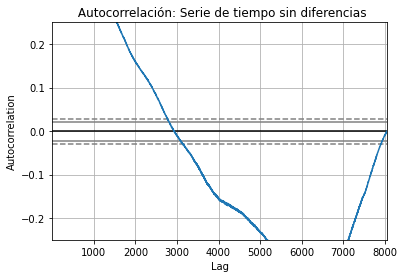

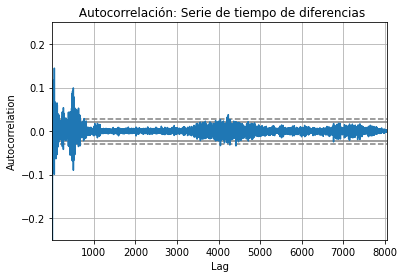

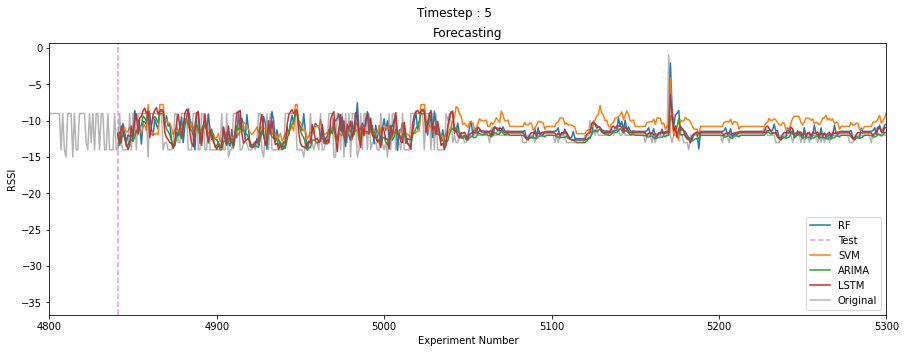

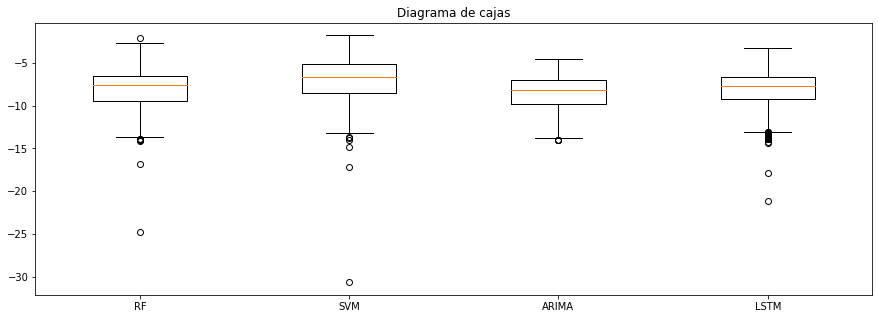

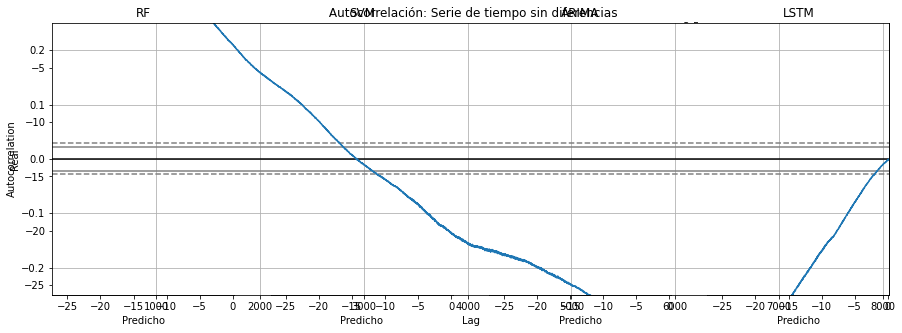

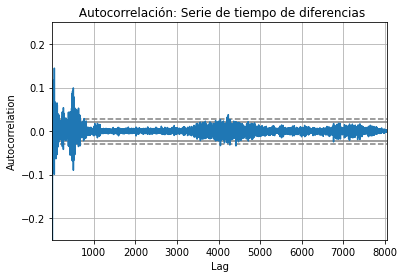

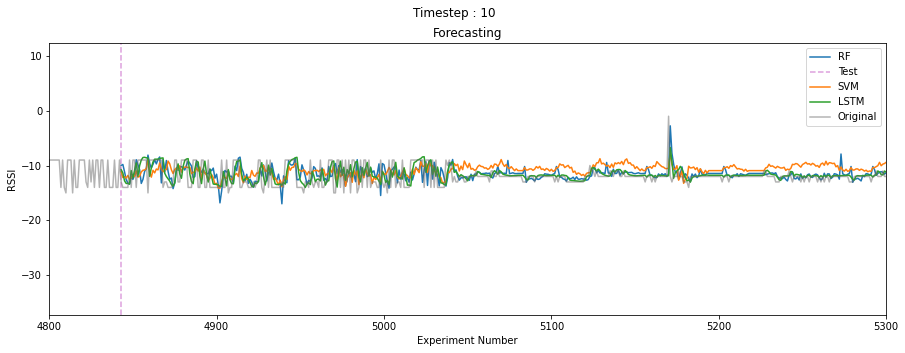

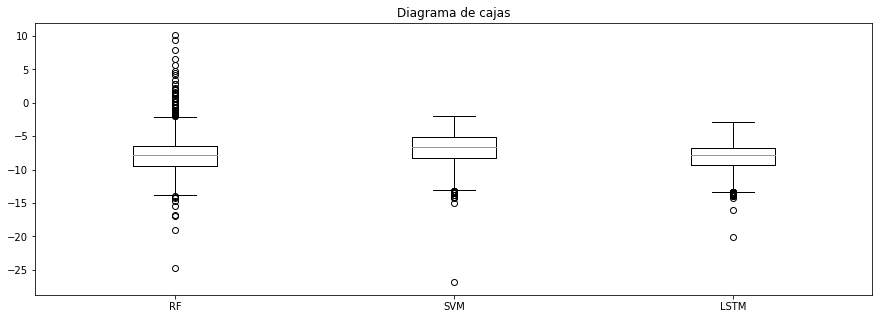

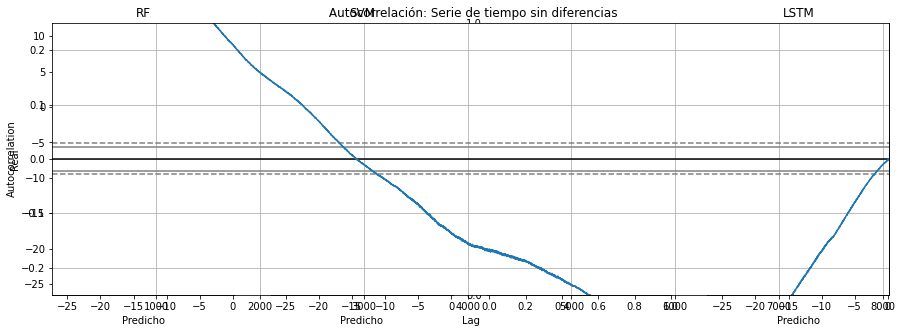

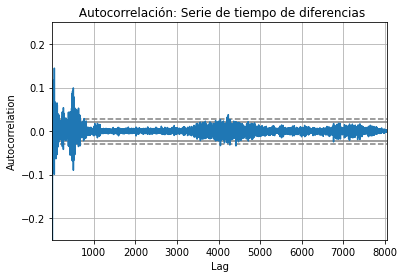

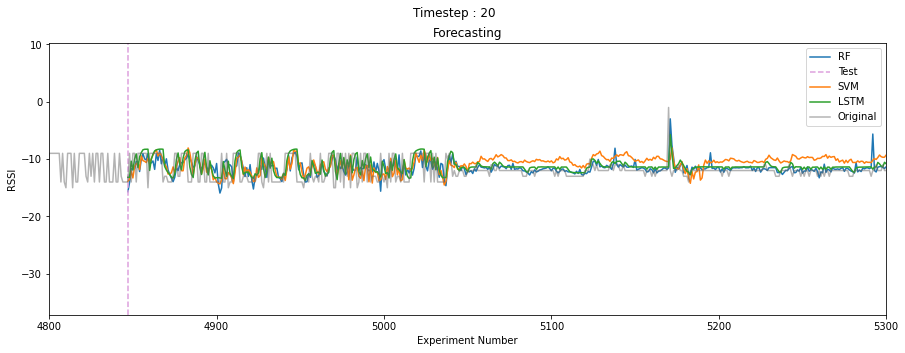

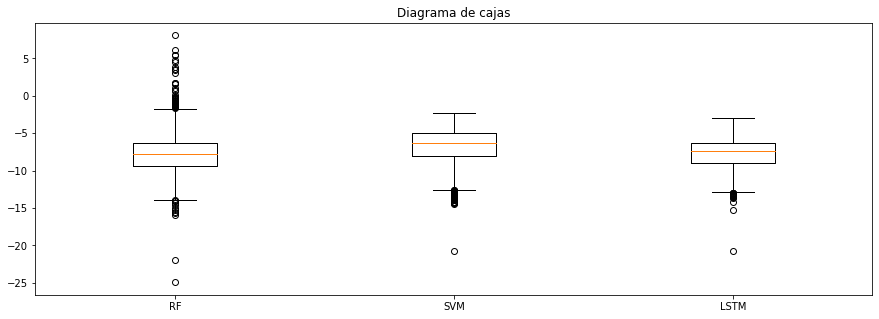

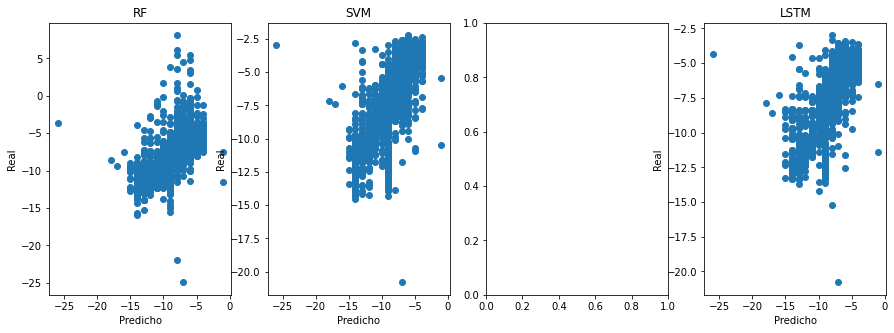

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Dataset limpios/10m/raw_data_run11--1.csv", "RSSI", True, False)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


*************************************************************************
{'Errores modelo RF : 5': (2.803, 1.076, 31.84, 0.603, 21.472, 0.468)}
{'Errores modelo SVR : 5': (2.873, 1.122, 31.869, 0.652, 21.793, 0.455)}
{'Errores modelo ARIMA : 5': (1.589, 0.781, 10.335, 0.473, 20.358, 0.699)}
{'Errores modelo LSTM : 5': (2.629, 1.013, 31.769, 0.651, 21.308, 0.502)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 2.8573644161224365}
{'Tiempo modelo SVR :  5': 0.41484808921813965}
{'Tiempo modelo ARIMA : 5': 4408.501667022705}
{'Tiempo modelo LSTM : 5': 604.3089323043823}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (2.873, 1.097, 32.026, 0.633, 21.52, 0.455)}
{'Errores modelo SVR : 10': (2.787, 1.078, 32.028, 0.595, 21.555, 0.471)}
{}
{'Errores modelo LSTM : 10': (2.688, 1.042, 31.773, 0.55, 21.426, 0.49)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 5.887356519699097}
{'Tiempo modelo SVR :  10': 0.4488065242767334}
{}
{'Tiempo modelo LSTM : 10': 902.72407746315}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.466988
Valor p: 0.549774
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (2.747, 1.064, 31.823, 0.591, 21.451, 0.476)}
{'Errores modelo SVR : 20': (2.886, 1.123, 32.156, 0.641, 21.874, 0.449)}
{}
{'Errores modelo LSTM : 20': (2.648, 1.022, 31.693, 0.574, 21.364, 0.495)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 12.196438074111938}
{'Tiempo modelo SVR :  20': 0.5102639198303223}
{}
{'Tiempo modelo LSTM : 20': 1350.7293293476105}
*************************************************************************


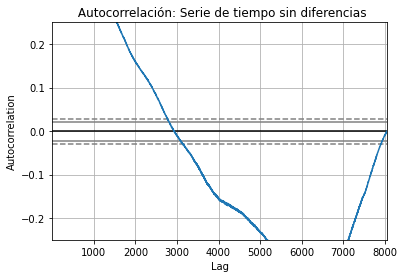

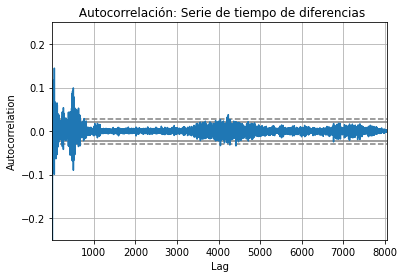

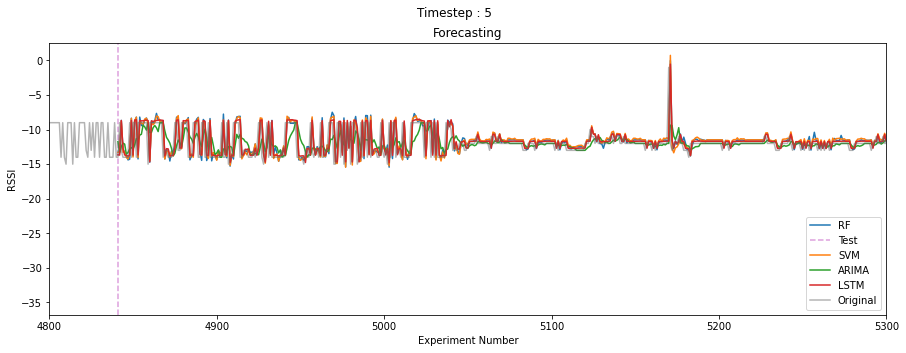

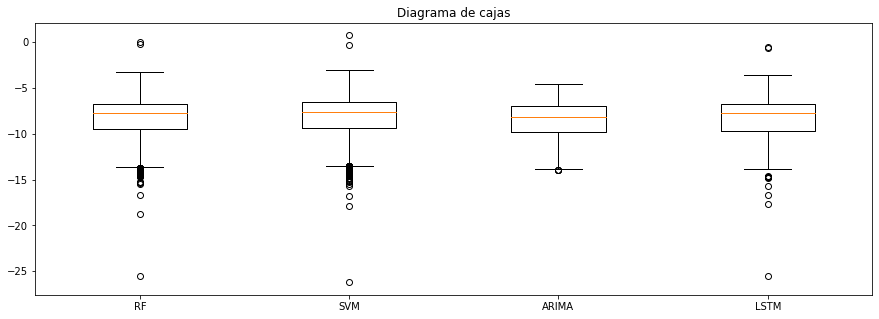

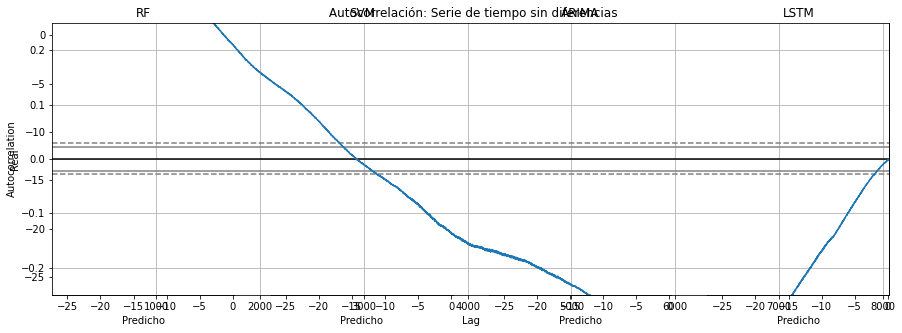

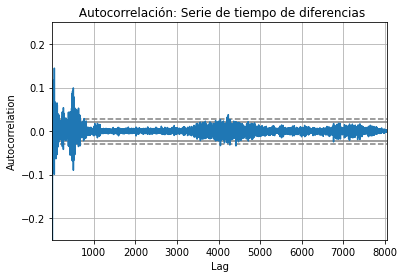

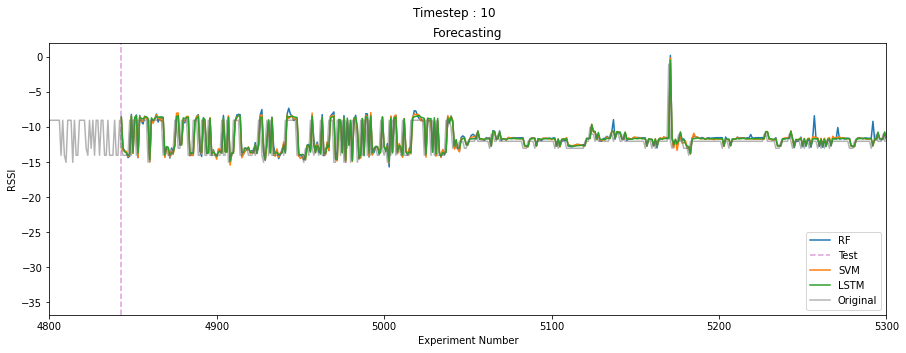

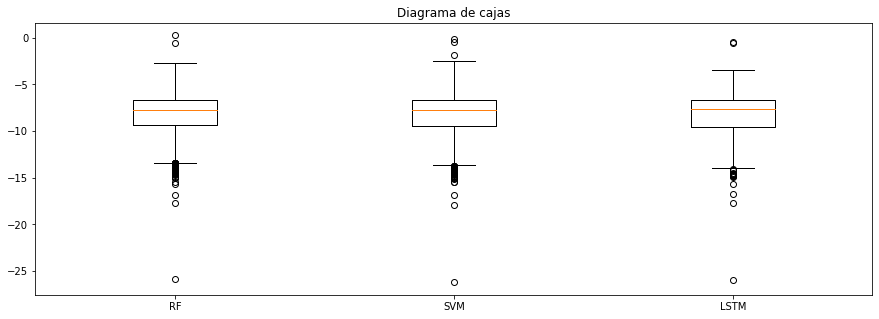

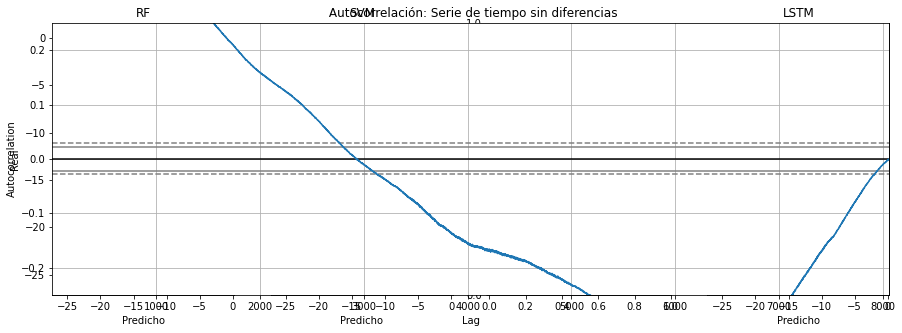

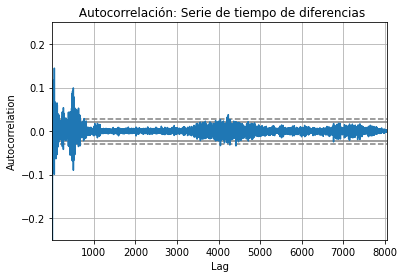

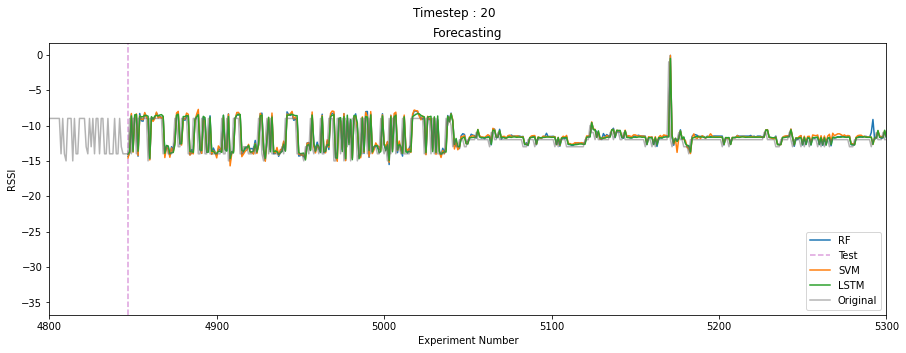

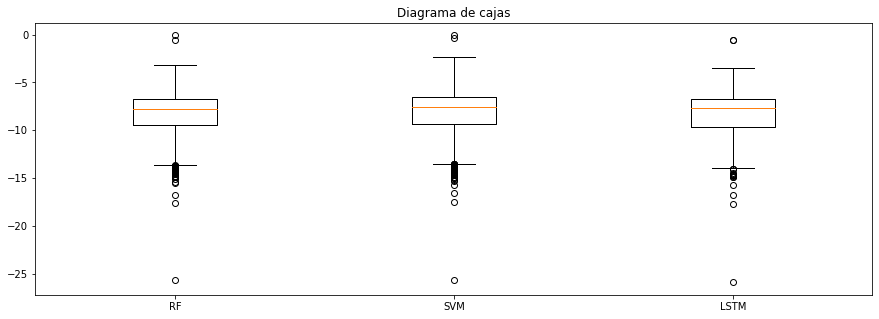

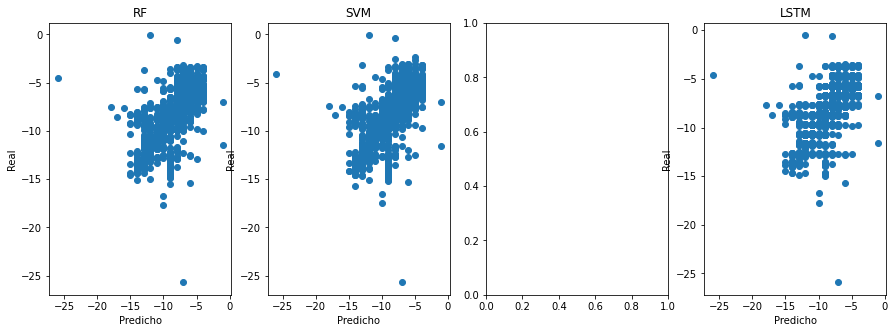

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Dataset limpios/10m/raw_data_run11--1.csv", "RSSI", True, True)

# 15M RSSI


---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opt

*************************************************************************
{'Errores modelo RF : 5': (0.779, 0.67, 10.149, 0.554, 15.446, 0.656)}
{'Errores modelo SVR : 5': (12.718, 3.518, 20.246, 3.482, 12.518, -4.613)}
{'Errores modelo ARIMA : 5': (0.301, 0.244, 1.789, 0.0, 16.0, 0.867)}
{'Errores modelo LSTM : 5': (1.303, 1.012, 10.501, 0.956, 15.044, 0.425)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 0.9677739143371582}
{'Tiempo modelo SVR :  5': 0.12910008430480957}
{'Tiempo modelo ARIMA : 5': 804.5581789016724}
{'Tiempo modelo LSTM : 5': 593.4972574710846}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (5.805, 0.967, 11.452, 0.553, 29.55, -1.568)}
{'Errores modelo SVR : 10': (12.368, 3.475, 20.002, 3.482, 12.518, -4.473)}
{}
{'Errores modelo LSTM : 10': (0.545, 0.553, 9.758, 0.401, 15.599, 0.759)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 1.8580458164215088}
{'Tiempo modelo SVR :  10': 0.2171950340270996}
{}
{'Tiempo modelo LSTM : 10': 840.7966492176056}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (4.046, 0.945, 11.08, 0.531, 23.649, -0.798)}
{'Errores modelo SVR : 20': (12.16, 3.446, 19.835, 3.459, 12.541, -4.403)}
{}
{'Errores modelo LSTM : 20': (0.467, 0.48, 9.62, 0.314, 15.686, 0.793)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 3.9053122997283936}
{'Tiempo modelo SVR :  20': 0.2441253662109375}
{}
{'Tiempo modelo LSTM : 20': 1340.8862659931183}
*************************************************************************


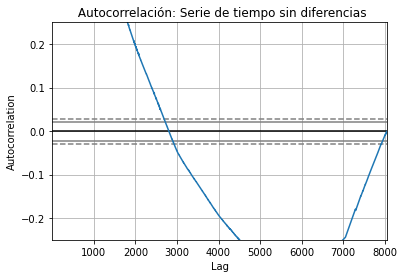

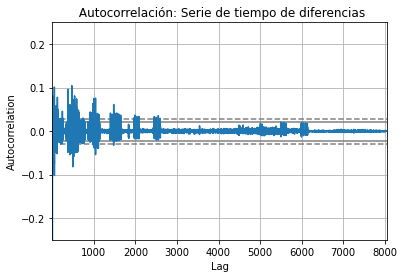

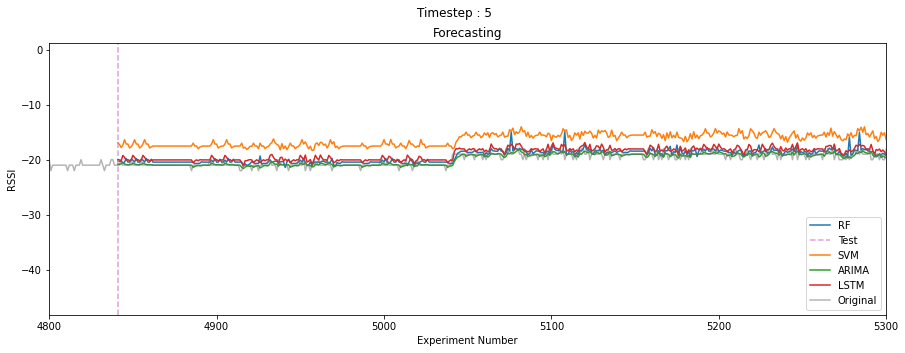

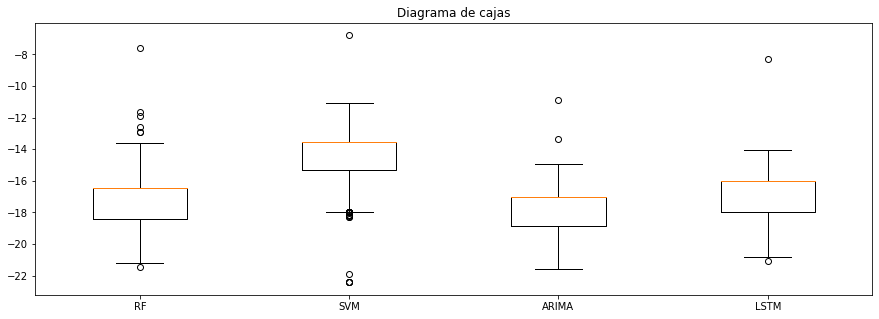

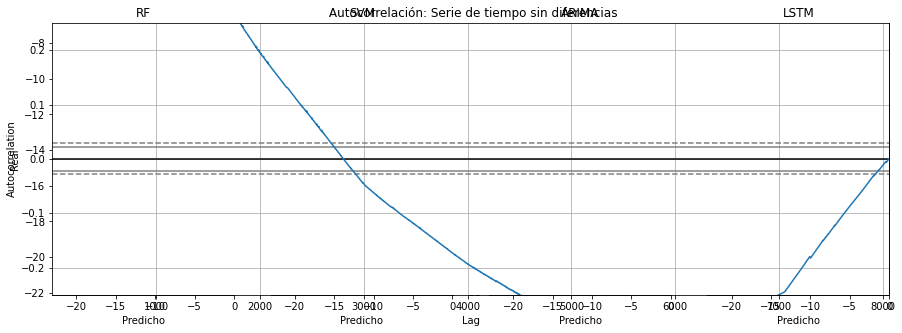

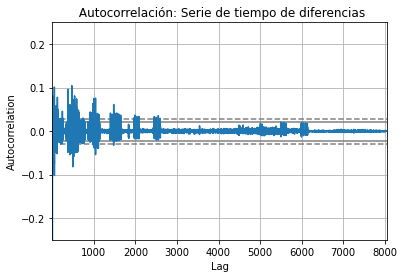

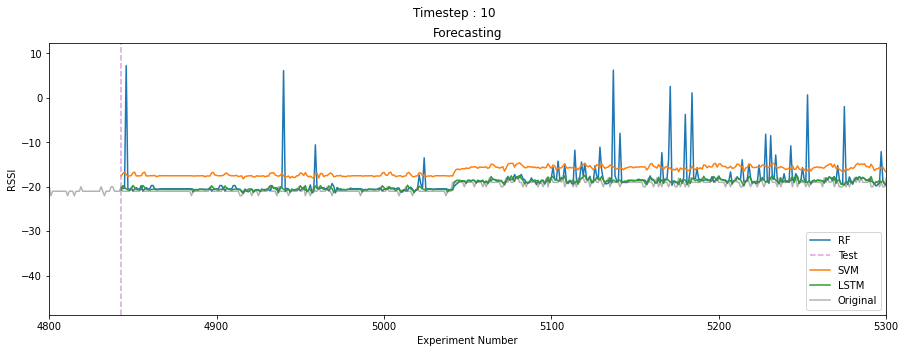

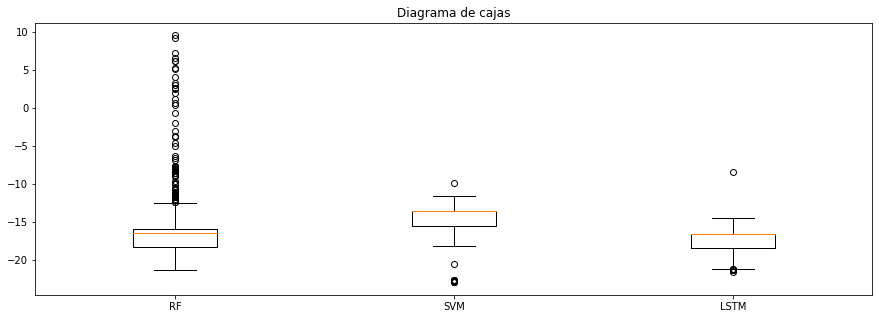

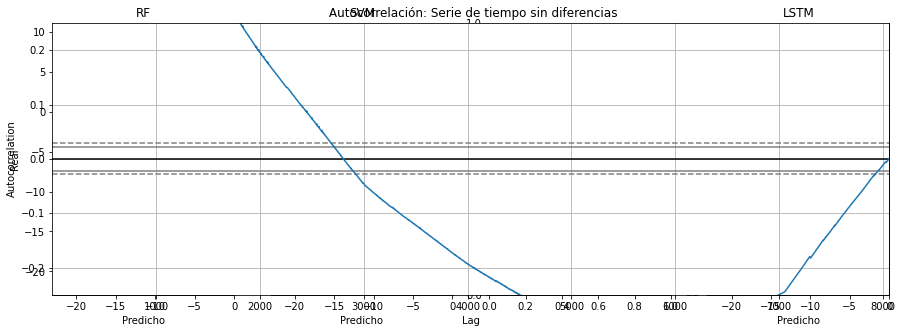

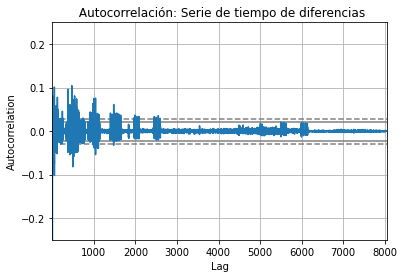

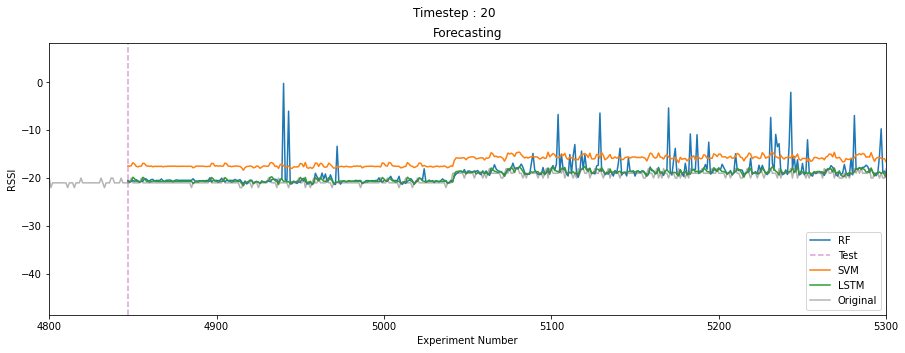

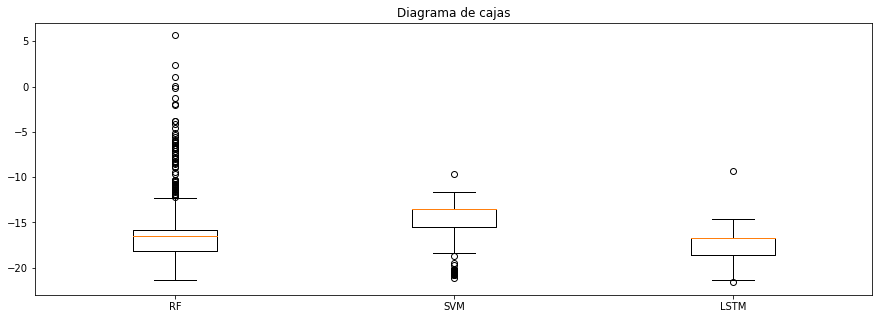

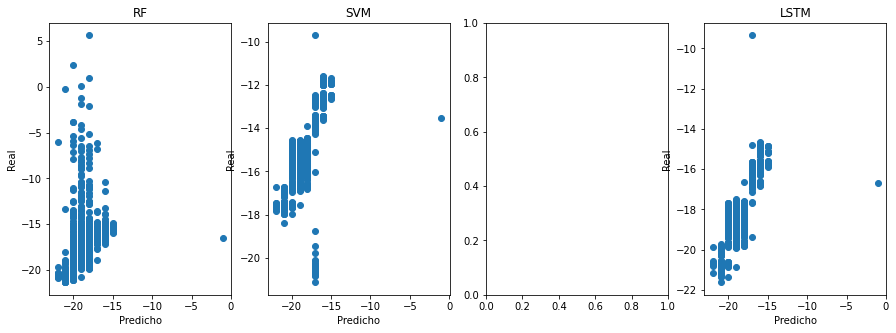

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Dataset limpios/15m/raw_data_run2--1.csv", "RSSI", True, False)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opt

*************************************************************************
{'Errores modelo RF : 5': (0.873, 0.663, 10.215, 0.513, 16.531, 0.615)}
{'Errores modelo SVR : 5': (1.42, 1.037, 10.956, 1.054, 16.8, 0.373)}
{'Errores modelo ARIMA : 5': (0.301, 0.244, 1.789, 0.0, 16.0, 0.867)}
{'Errores modelo LSTM : 5': (0.594, 0.527, 9.805, 0.334, 16.359, 0.738)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 1.5350141525268555}
{'Tiempo modelo SVR :  5': 0.16327214241027832}
{'Tiempo modelo ARIMA : 5': 797.1421790122986}
{'Tiempo modelo LSTM : 5': 575.6351928710938}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (0.908, 0.67, 10.16, 0.501, 16.576, 0.598)}
{'Errores modelo SVR : 10': (1.421, 1.032, 10.902, 1.042, 17.639, 0.371)}
{}
{'Errores modelo LSTM : 10': (0.688, 0.611, 9.996, 0.45, 17.09, 0.696)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 3.05944561958313}
{'Tiempo modelo SVR :  10': 0.17634844779968262}
{}
{'Tiempo modelo LSTM : 10': 856.2344403266907}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (0.738, 0.638, 10.081, 0.503, 16.862, 0.672)}
{'Errores modelo SVR : 20': (1.363, 1.006, 10.783, 1.005, 17.419, 0.394)}
{}
{'Errores modelo LSTM : 20': (0.717, 0.638, 10.085, 0.5, 17.217, 0.681)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 6.462168455123901}
{'Tiempo modelo SVR :  20': 0.24493002891540527}
{}
{'Tiempo modelo LSTM : 20': 1321.3372325897217}
*************************************************************************


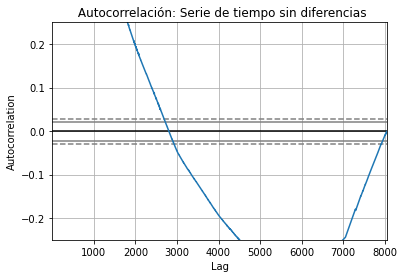

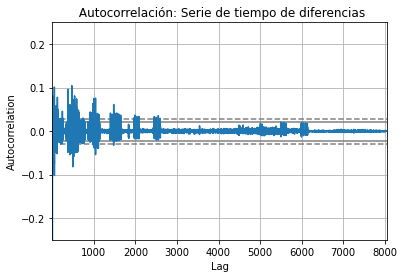

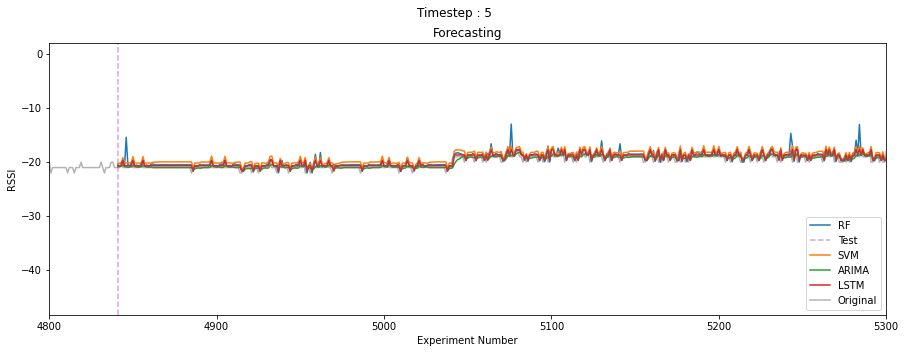

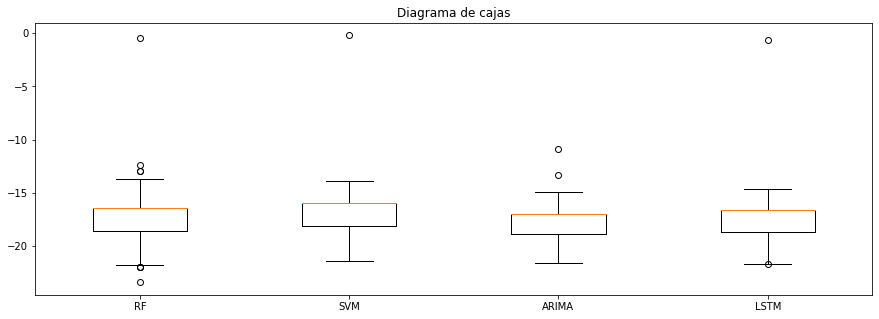

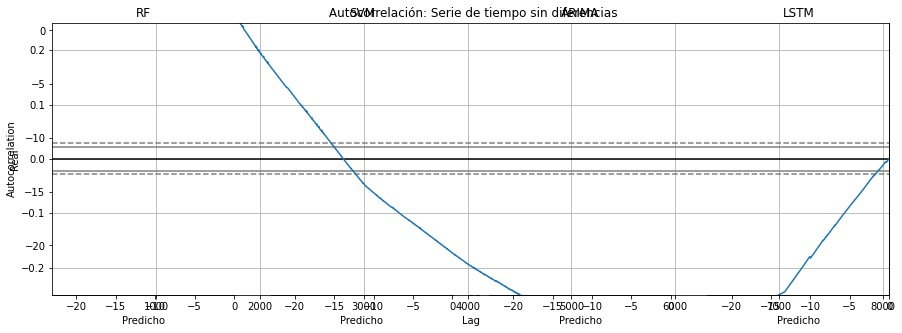

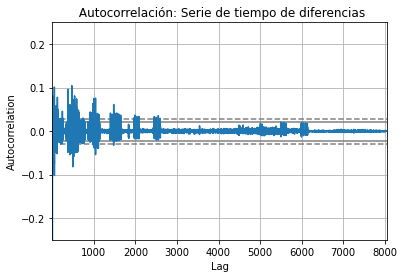

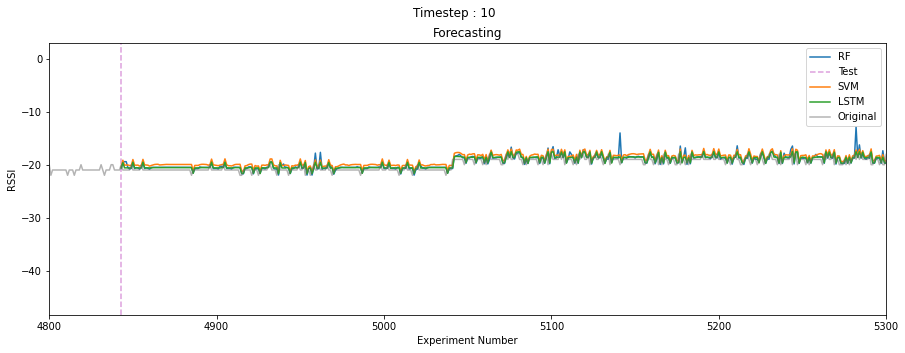

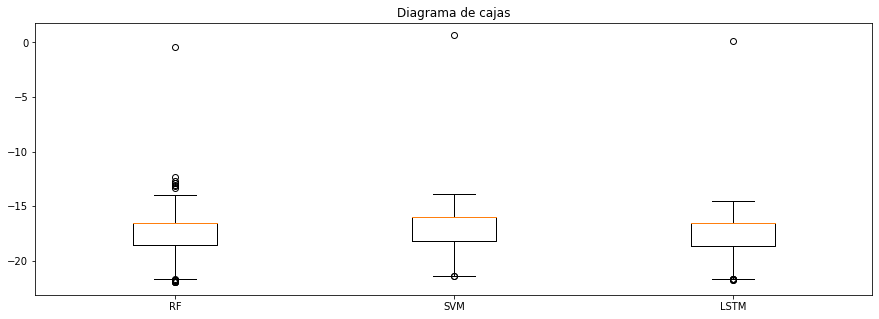

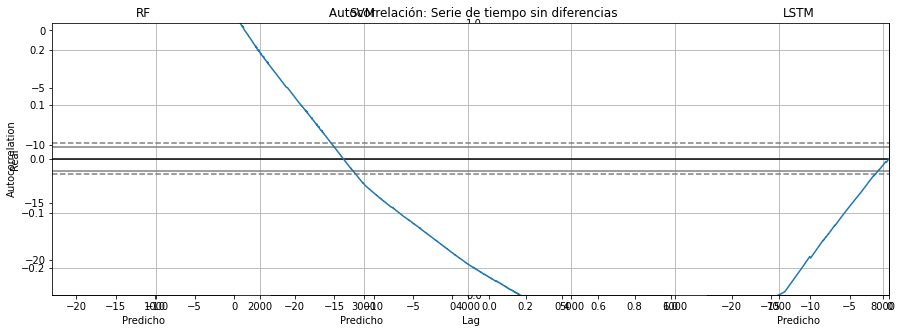

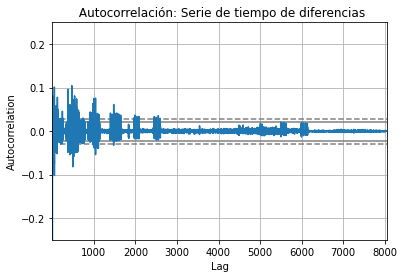

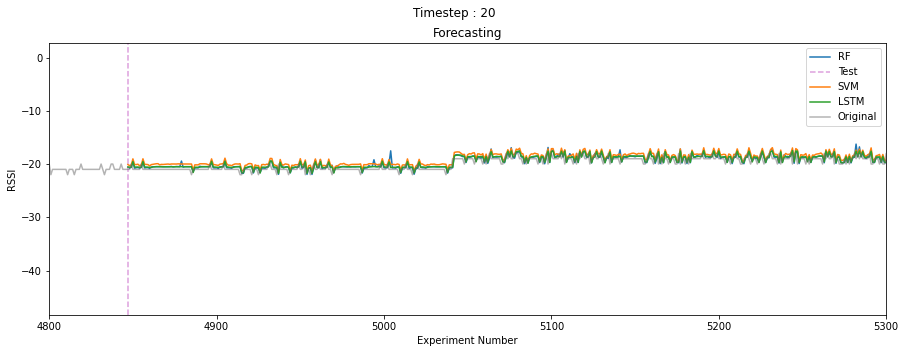

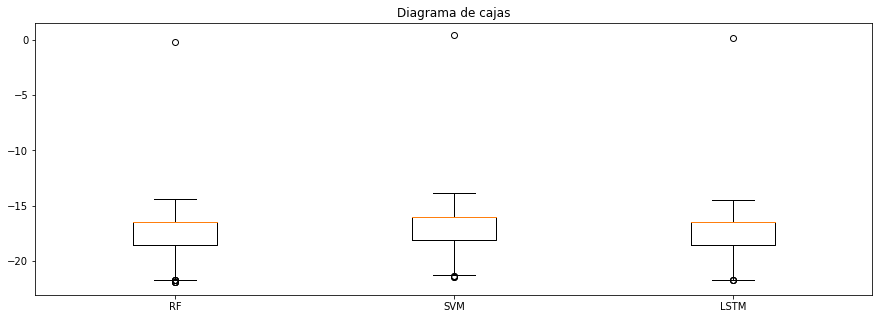

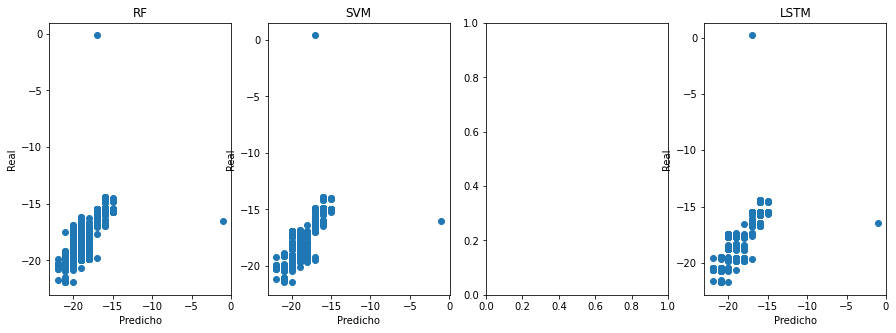

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Dataset limpios/15m/raw_data_run2--1.csv", "RSSI", True, True)

# 10M LQI

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 5': (1.213, 0.731, 18.451, 0.463, 15.762, 0.602)}
{'Errores modelo SVR : 5': (0.831, 0.704, 18.284, 0.457, 3.97, 0.728)}
{'Errores modelo ARIMA : 5': (0.382, 0.444, 3.781, 0.354, 3.0, 0.875)}
{'Errores modelo LSTM : 5': (0.672, 0.638, 17.861, 0.357, 3.379, 0.78)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 1.69073486328125}
{'Tiempo modelo SVR :  5': 0.1926121711730957}
{'Tiempo modelo ARIMA : 5': 4315.856318950653}
{'Tiempo modelo LSTM : 5': 593.4751145839691}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (2.68, 0.842, 19.369, 0.456, 18.853, 0.122)}
{'Errores modelo SVR : 10': (0.843, 0.699, 18.001, 0.503, 4.119, 0.724)}
{}
{'Errores modelo LSTM : 10': (0.597, 0.579, 17.747, 0.279, 3.262, 0.804)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 3.582362651824951}
{'Tiempo modelo SVR :  10': 0.2478008270263672}
{}
{'Tiempo modelo LSTM : 10': 836.0172078609467}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (1.602, 0.76, 18.652, 0.49, 17.64, 0.476)}
{'Errores modelo SVR : 20': (1.031, 0.784, 18.448, 0.607, 4.259, 0.663)}
{}
{'Errores modelo LSTM : 20': (0.584, 0.568, 17.756, 0.284, 3.255, 0.809)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 7.3049280643463135}
{'Tiempo modelo SVR :  20': 0.30762195587158203}
{}
{'Tiempo modelo LSTM : 20': 1318.9889705181122}
*************************************************************************


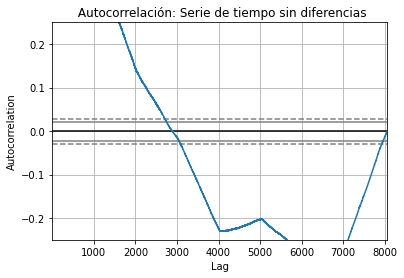

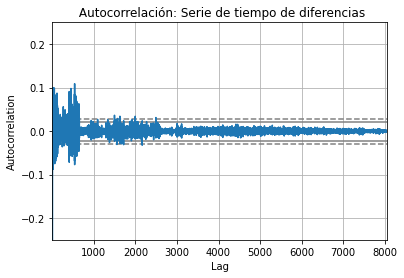

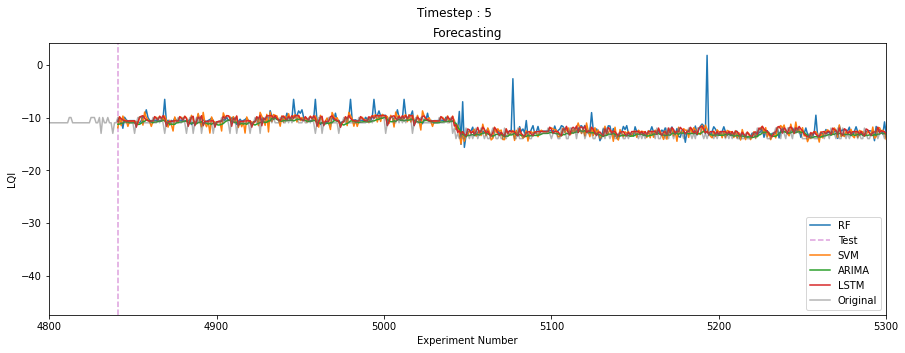

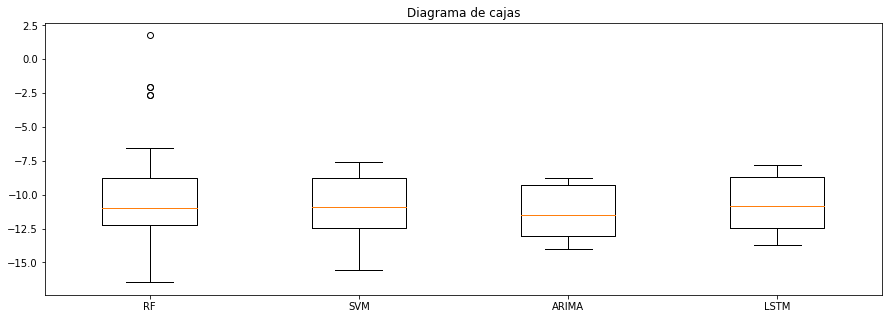

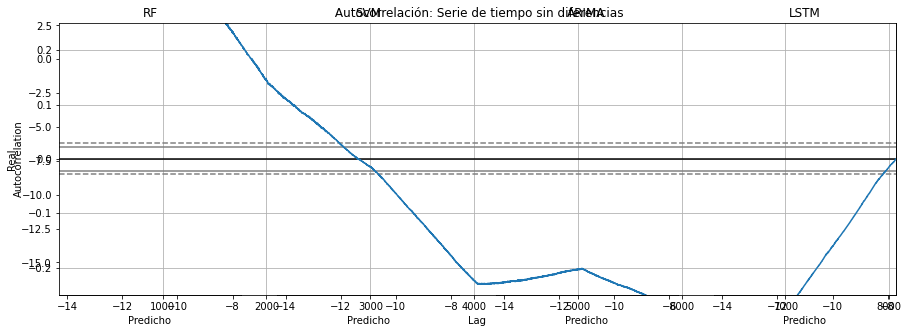

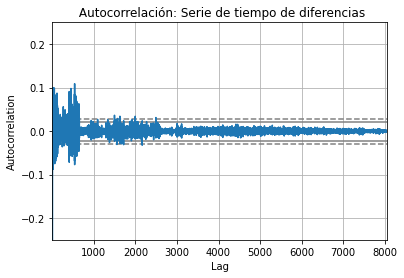

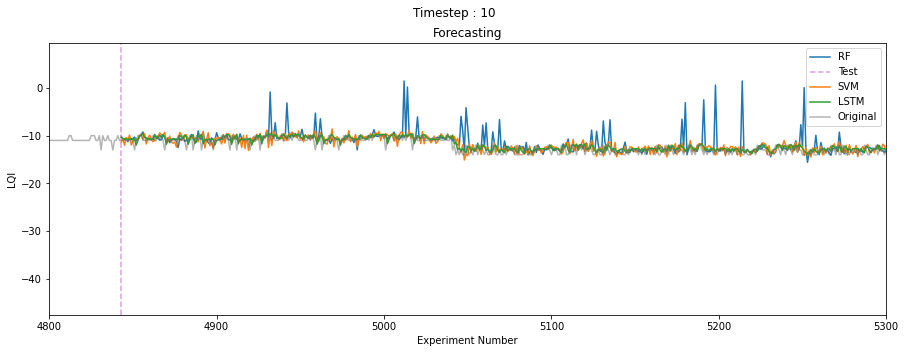

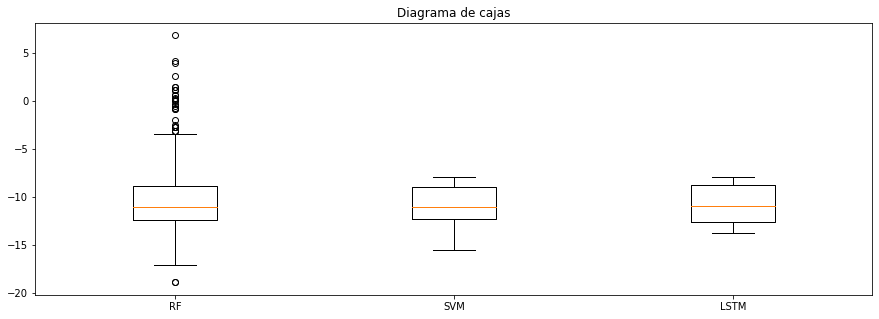

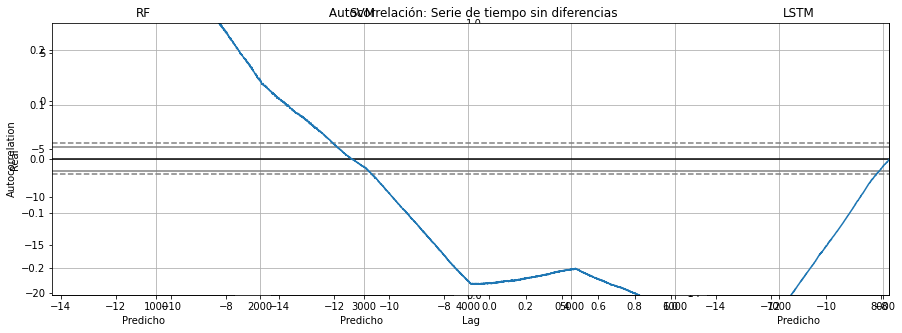

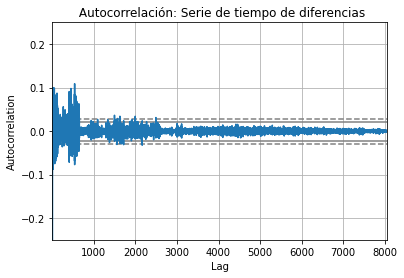

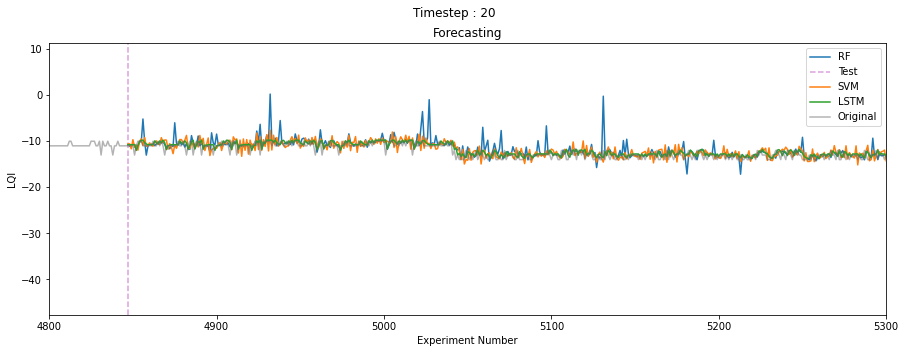

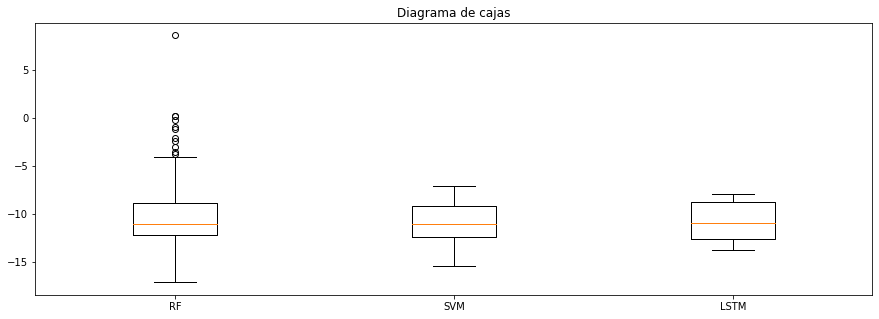

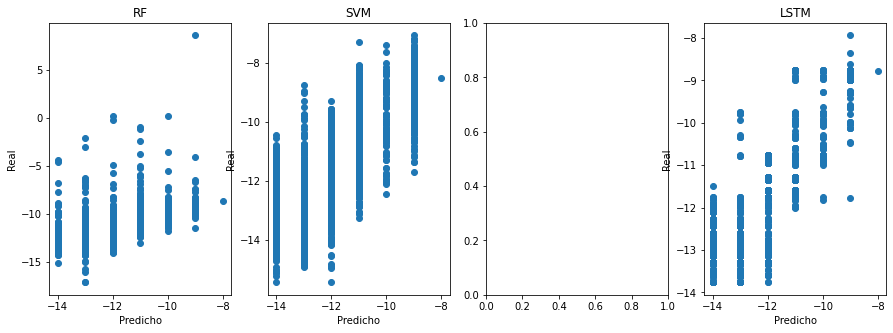

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Datset Limpios LQI/10m/raw_data_run3--1.csv", "LQI", True, False)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 5': (0.853, 0.717, 18.714, 0.484, 3.815, 0.72)}
{'Errores modelo SVR : 5': (0.786, 0.684, 18.514, 0.393, 3.449, 0.743)}
{'Errores modelo ARIMA : 5': (0.382, 0.444, 3.781, 0.354, 3.0, 0.875)}
{'Errores modelo LSTM : 5': (0.752, 0.672, 18.345, 0.352, 3.36, 0.754)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 2.5510268211364746}
{'Tiempo modelo SVR :  5': 0.25551795959472656}
{'Tiempo modelo ARIMA : 5': 4305.877490997314}
{'Tiempo modelo LSTM : 5': 608.4220609664917}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (0.85, 0.716, 18.682, 0.488, 3.933, 0.721)}
{'Errores modelo SVR : 10': (0.801, 0.672, 18.373, 0.421, 3.482, 0.738)}
{}
{'Errores modelo LSTM : 10': (0.691, 0.593, 18.355, 0.254, 3.284, 0.774)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 5.4585065841674805}
{'Tiempo modelo SVR :  10': 0.3202512264251709}
{}
{'Tiempo modelo LSTM : 10': 884.9241299629211}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.528370
Valor p: 0.519434
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (0.831, 0.71, 18.728, 0.498, 3.44, 0.728)}
{'Errores modelo SVR : 20': (0.816, 0.693, 18.535, 0.461, 3.783, 0.733)}
{}
{'Errores modelo LSTM : 20': (0.785, 0.703, 18.493, 0.416, 3.433, 0.743)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 11.40902590751648}
{'Tiempo modelo SVR :  20': 0.3238086700439453}
{}
{'Tiempo modelo LSTM : 20': 1359.6627249717712}
*************************************************************************


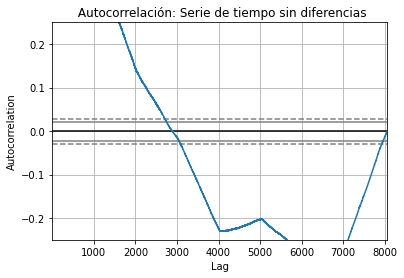

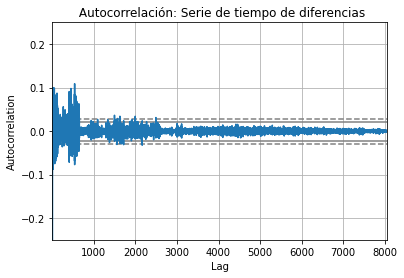

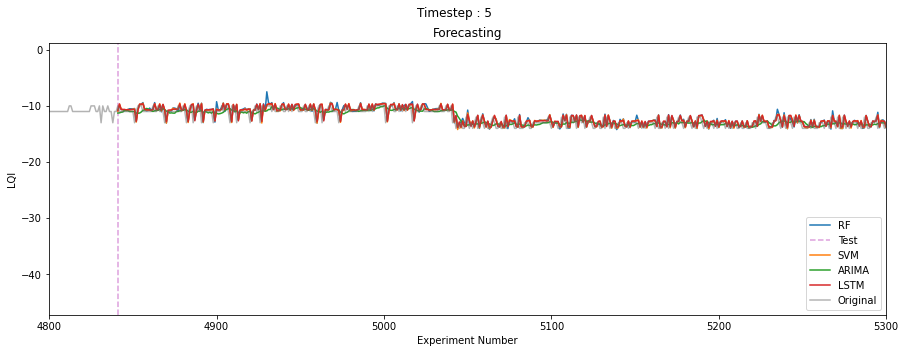

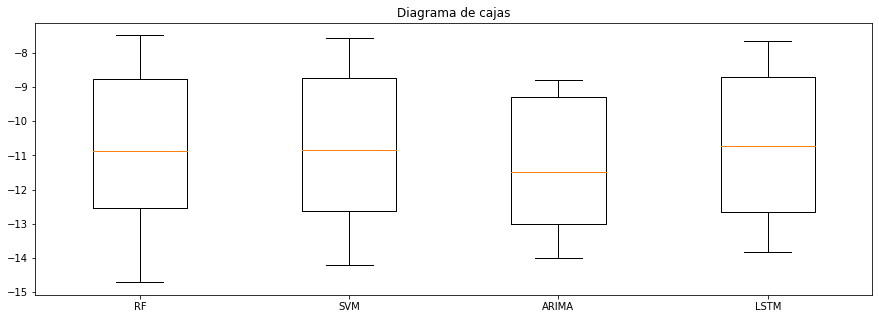

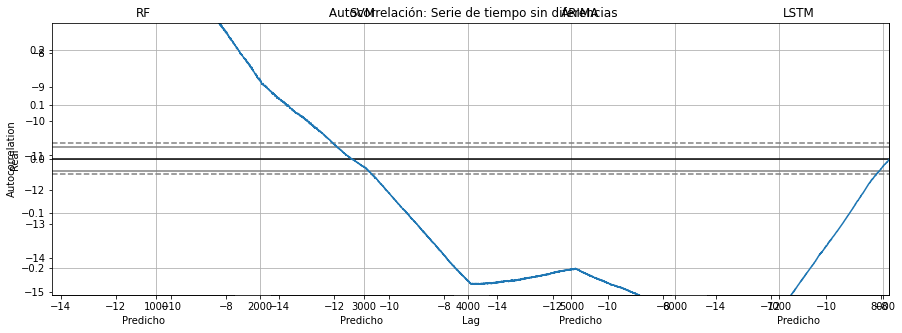

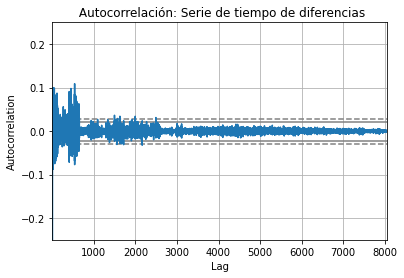

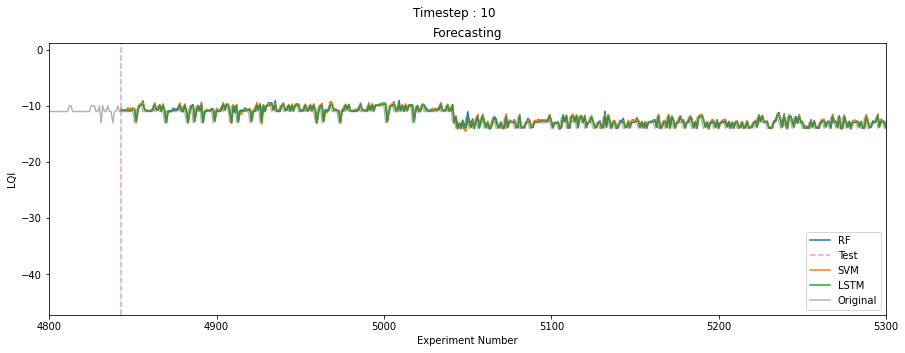

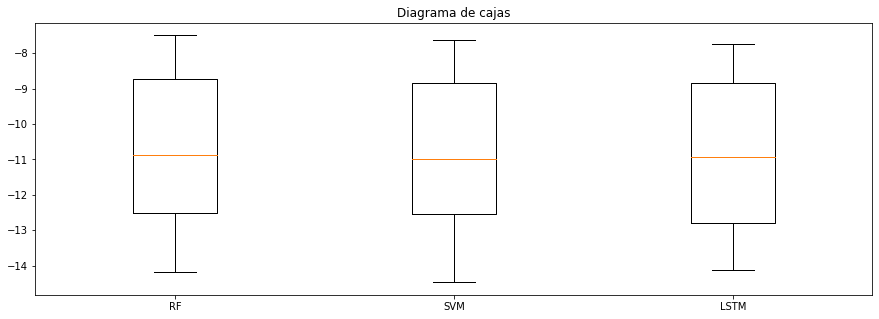

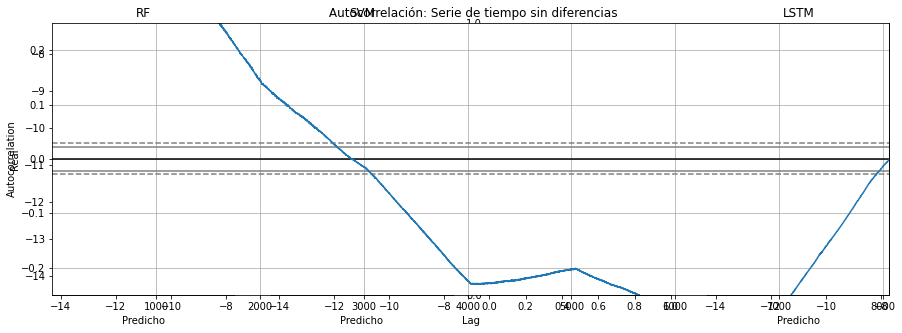

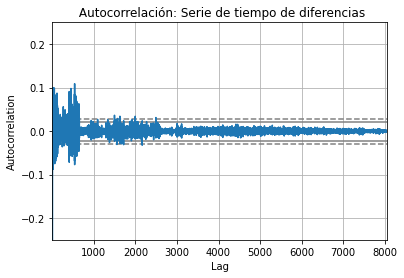

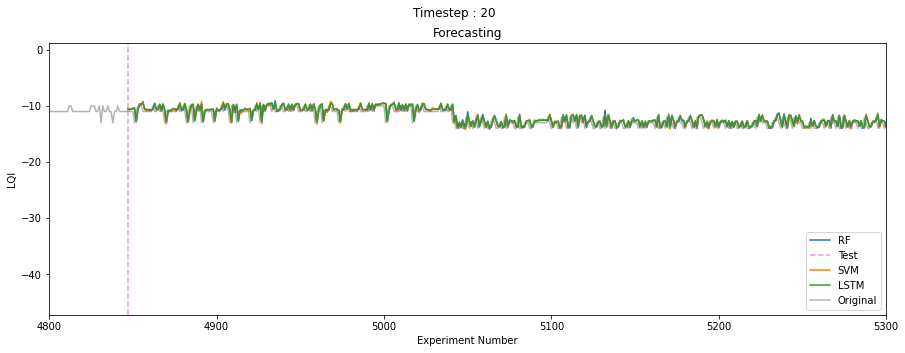

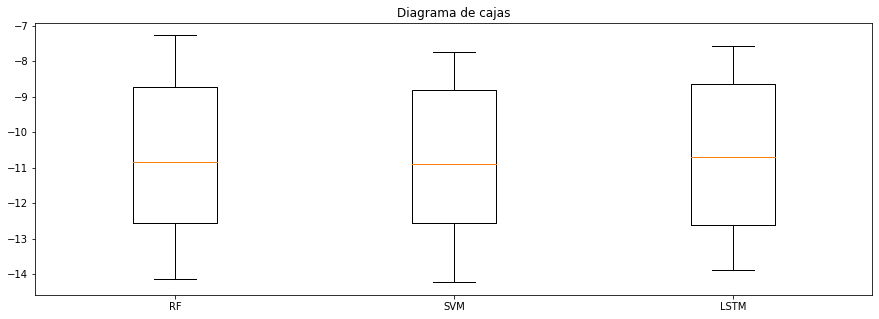

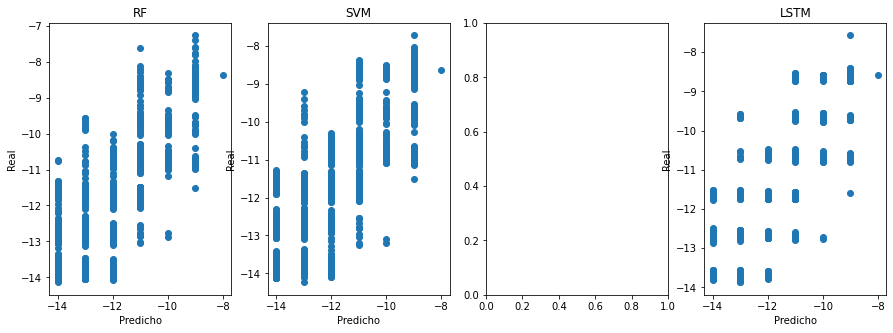

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Datset Limpios LQI/10m/raw_data_run3--1.csv", "LQI", True, True)

# 15M 

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opt

*************************************************************************
{'Errores modelo RF : 5': (0.817, 0.672, 10.168, 0.553, 15.447, 0.639)}
{'Errores modelo SVR : 5': (12.718, 3.518, 20.246, 3.482, 12.518, -4.613)}
{'Errores modelo ARIMA : 5': (0.301, 0.244, 1.789, 0.0, 16.0, 0.867)}
{'Errores modelo LSTM : 5': (0.596, 0.601, 9.833, 0.469, 15.531, 0.737)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 5': 0.9709787368774414}
{'Tiempo modelo SVR :  5': 0.13111281394958496}
{'Tiempo modelo ARIMA : 5': 802.8339378833771}
{'Tiempo modelo LSTM : 5': 586.796783208847}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 10': (5.415, 0.957, 11.369, 0.552, 27.517, -1.396)}
{'Errores modelo SVR : 10': (12.368, 3.475, 20.002, 3.482, 12.518, -4.473)}
{}
{'Errores modelo LSTM : 10': (0.506, 0.516, 9.685, 0.351, 15.649, 0.776)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 10': 1.8784868717193604}
{'Tiempo modelo SVR :  10': 0.21088576316833496}
{}
{'Tiempo modelo LSTM : 10': 883.5871822834015}
*************************************************************************
---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (4.619, 0.972, 11.199, 0.524, 25.518, -1.053)}
{'Errores modelo SVR : 20': (12.16, 3.446, 19.835, 3.459, 12.541, -4.403)}
{}
{'Errores modelo LSTM : 20': (0.558, 0.551, 9.748, 0.381, 15.619, 0.752)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 3.867443084716797}
{'Tiempo modelo SVR :  20': 0.24334502220153809}
{}
{'Tiempo modelo LSTM : 20': 1364.4517176151276}
*************************************************************************


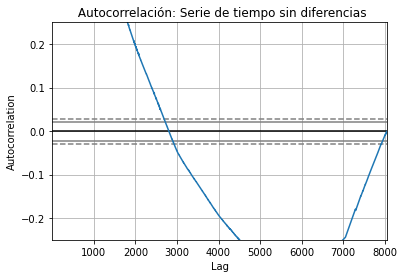

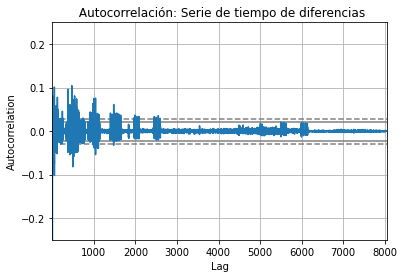

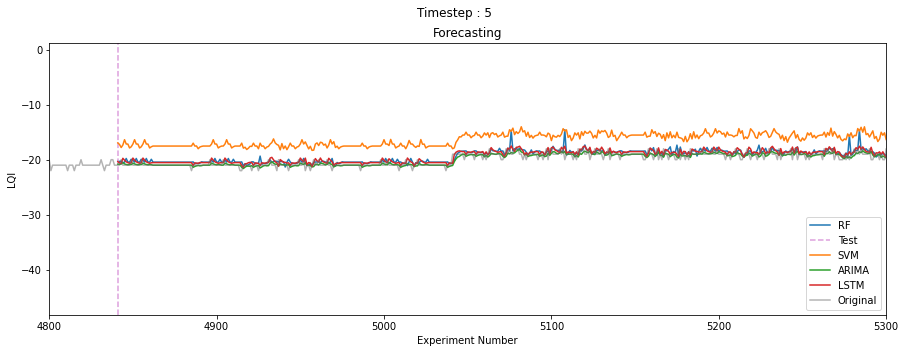

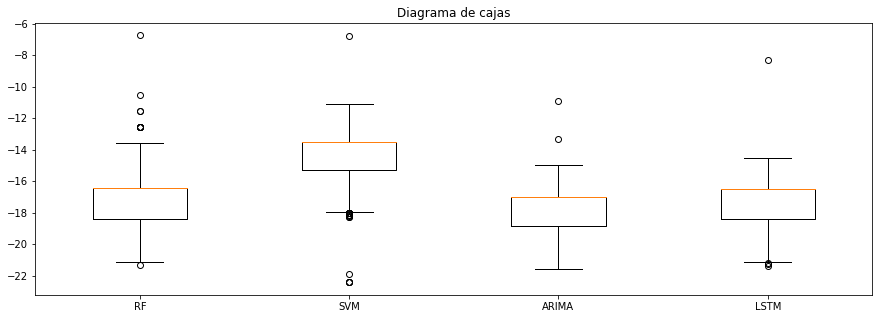

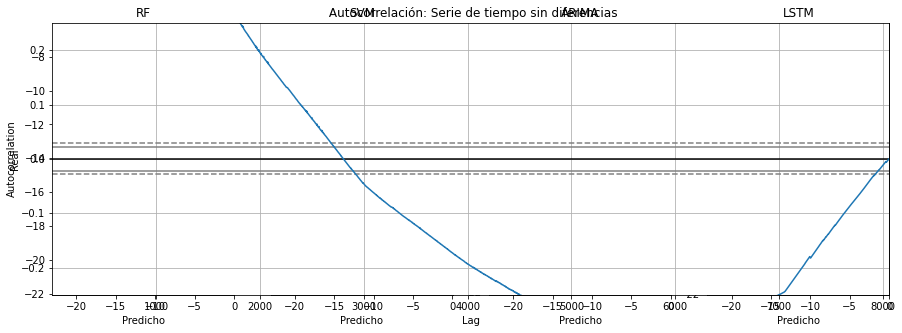

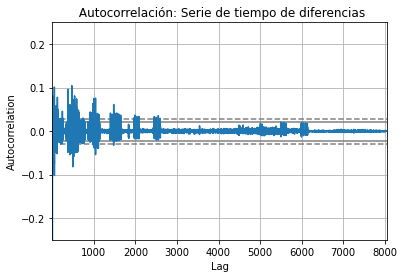

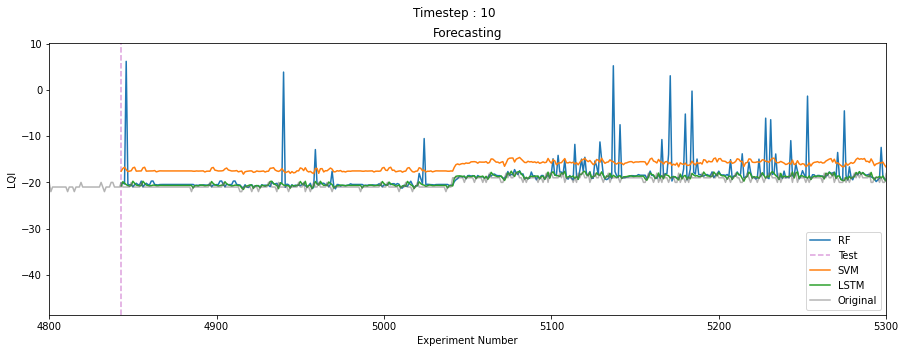

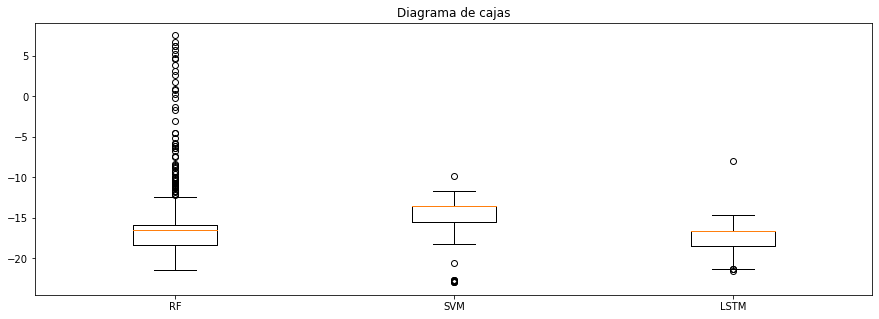

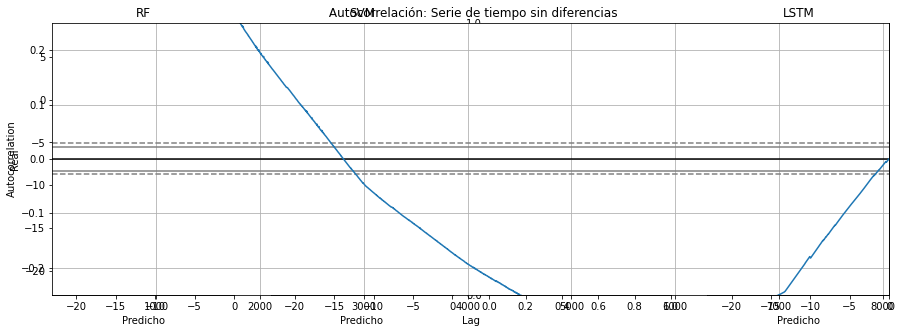

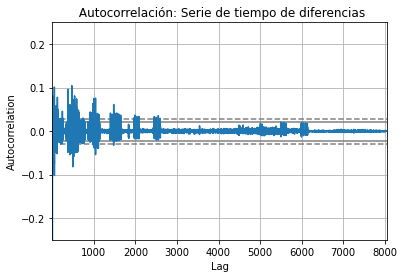

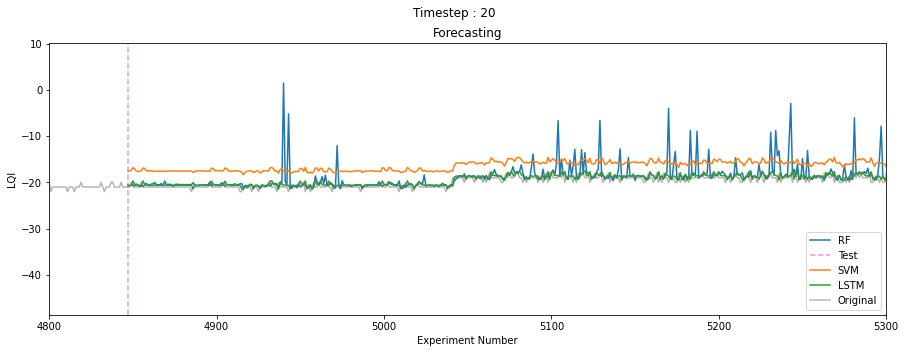

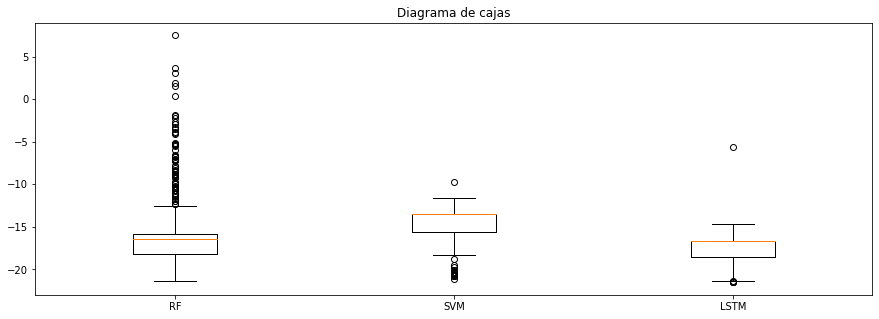

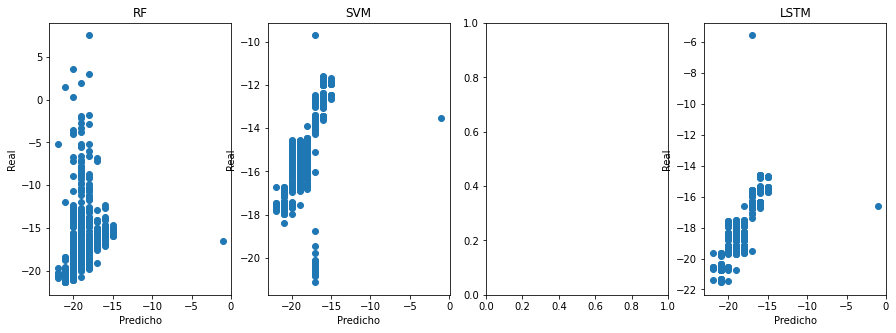

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Datset Limpios LQI/15m/raw_data_run2--1.csv", "LQI", True, False)

---------------------- DICKEY - FULLER ----------------------
ADF Estadistico: -1.381229
Valor p: 0.591241
Valores críticos
	1%: -3.43116
	5%: -2.86190
	10%: -2.56696
-------------------------------------------------------------
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:199: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*************************************************************************
{'Errores modelo RF : 20': (0.736, 0.638, 10.077, 0.504, 16.857, 0.673)}
{'Errores modelo SVR : 20': (1.363, 1.006, 10.783, 1.005, 17.419, 0.394)}
{}
{'Errores modelo LSTM : 20': (0.678, 0.609, 9.997, 0.457, 16.823, 0.699)}
--------------------------------------------------------------------------
{'Tiempo modelo RF : 20': 6.435455799102783}
{'Tiempo modelo SVR :  20': 0.231398344039917}
{}
{'Tiempo modelo LSTM : 20': 1235.7607226371765}
*************************************************************************


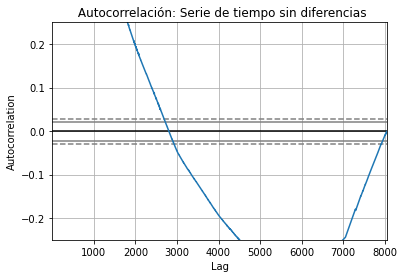

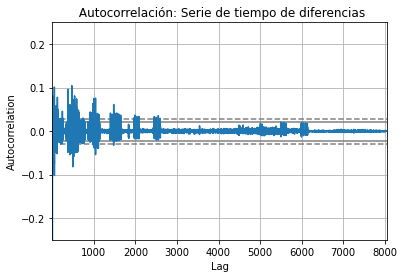

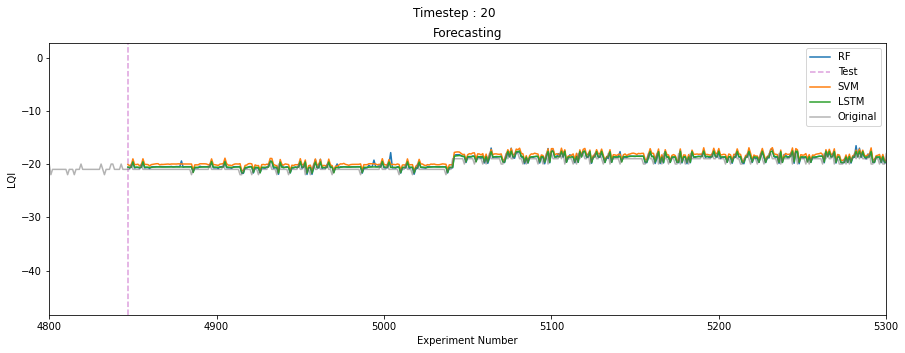

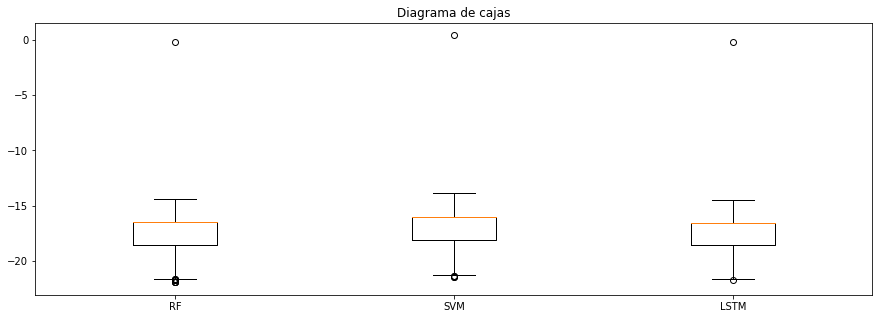

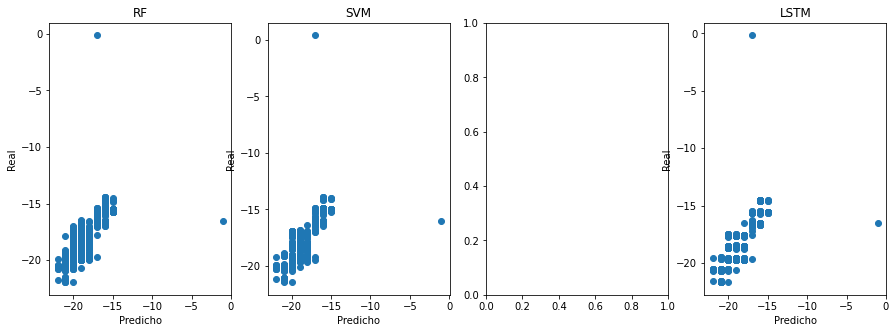

In [ ]:
automatizar("/content/drive/MyDrive/PROYECTO -- EXPERIMENTOS/Script limpiar datasets/Datset Limpios LQI/15m/raw_data_run2--1.csv", "LQI", True, True)